# High-Frequency Data and Limit Order Books
## Lab 1

By: Imad AMRI, Nessrine CHIBA, Adonis JAMAL

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os

---
## 1. Trades Analysis

This section deals with trades data only. We will analyze various aspects of the trade data including:
1. General statistical analysis
2. Tick size measurement
3. Intraday trading activity
4. Volatility-volume relationship
5. High-frequency log-returns distributions

---
### 1.1 Dataset: General statistical analyses

In [77]:
# Import data
trades = np.array([[pd.read_csv(f"Data/stock{i}_day{j}_trades.csv.gz") for i in range(0, 3)] for j in range(0, 5)], dtype=object)
df = pd.concat([df.assign(stock=i, day=j) for (j, i), df in np.ndenumerate(trades)], ignore_index=True)
print(f"Total number of trades: {len(df):,}")
print(f"Number of stocks: {df['stock'].nunique()}")
print(f"Number of days: {df['day'].nunique()}")

Total number of trades: 259,694
Number of stocks: 3
Number of days: 5


In [78]:
# Check for missing values and data quality
print("Data Quality Check")
print(f"\nMissing values per column:")
print(df.isnull().sum())
print(f"\nNaN values per column:")
print(df.isna().sum())

Data Quality Check

Missing values per column:
price    0
qty      0
ts       0
stock    0
day      0
dtype: int64

NaN values per column:
price    0
qty      0
ts       0
stock    0
day      0
dtype: int64


The data quality check shows no missing values or NaNs. We can proceed to computing additional columns and performing statistical analyses without worrying about any missing data.

In [ ]:
# Compute additional columns
df['ts'] = pd.to_datetime(df['ts'])
df['dt'] = df.groupby(['stock', 'day'])['ts'].diff().dt.total_seconds()
df['turnover'] = df['price'] * df['qty']


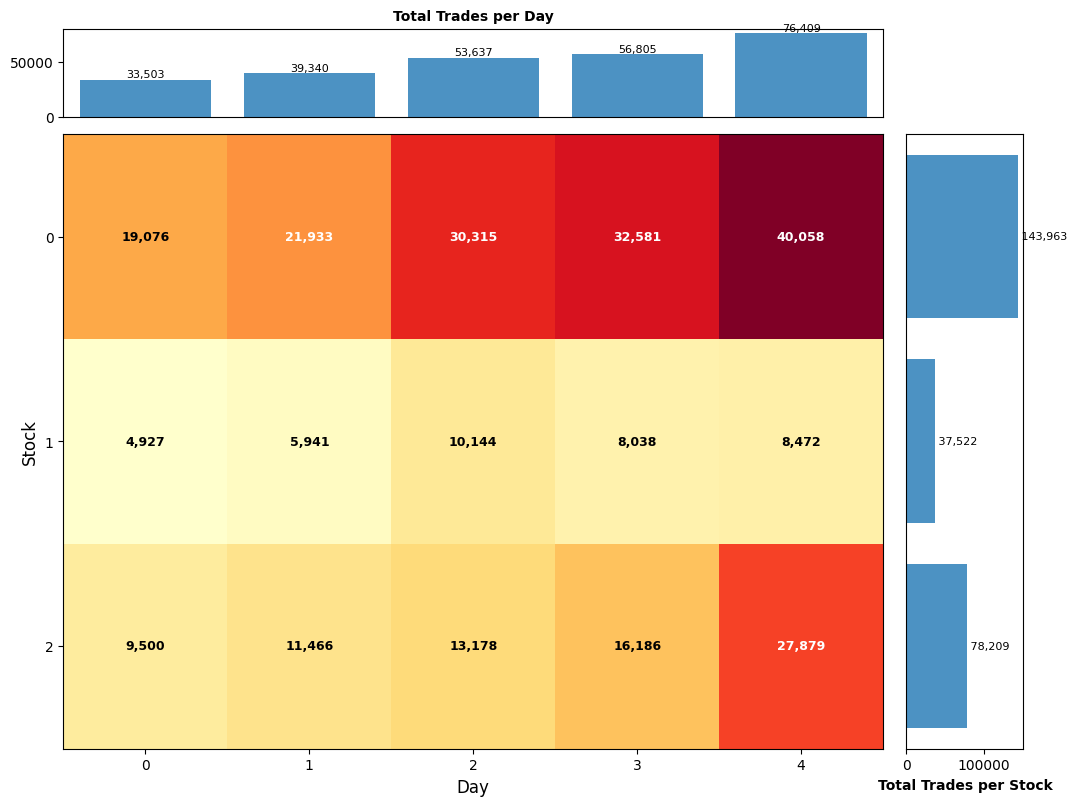

In [80]:
# Overall trade statistics
trades_matrix = df.pivot_table(index='stock', columns='day', values='ts', aggfunc='count', fill_value=0)
day_totals = trades_matrix.sum(axis=0)
stock_totals = trades_matrix.sum(axis=1)

fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1), height_ratios=(1, 7),
                    left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Trades per Day
ax_top = fig.add_subplot(gs[0, 0])
ax_top.bar(range(len(day_totals)), day_totals, alpha=0.8)
ax_top.set_xlim(-0.5, len(day_totals) - 0.5)
ax_top.set_xticks([])
ax_top.set_title("Total Trades per Day", fontsize=10, fontweight='bold')
for i, v in enumerate(day_totals):
    ax_top.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

# Trades per Stock
ax_right = fig.add_subplot(gs[1, 1])
ax_right.barh(range(len(stock_totals)), stock_totals, alpha=0.8)
ax_right.set_ylim(-0.5, len(stock_totals) - 0.5)
ax_right.set_yticks([])
ax_right.invert_yaxis()
ax_right.set_xlabel("Total Trades per Stock", fontsize=10, fontweight='bold')
for i, v in enumerate(stock_totals):
    ax_right.text(v, i, f' {v:,}', ha='left', va='center', fontsize=8)

# Heatmap
ax_main = fig.add_subplot(gs[1, 0])
im = ax_main.imshow(trades_matrix, aspect='auto', cmap='YlOrRd')

# Axis labels and ticks
ax_main.set_xticks(range(len(trades_matrix.columns)))
ax_main.set_xticklabels(trades_matrix.columns)
ax_main.set_yticks(range(len(trades_matrix.index)))
ax_main.set_yticklabels(trades_matrix.index)
ax_main.set_xlabel('Day', fontsize=12)
ax_main.set_ylabel('Stock', fontsize=12)

for i in range(len(trades_matrix.index)):
    for j in range(len(trades_matrix.columns)):
        val = trades_matrix.iloc[i, j]
        text_color = 'white' if val > trades_matrix.max().max() * 0.5 else 'black'
        ax_main.text(j, i, f'{int(val):,}', ha='center', va='center', 
                     color=text_color, fontsize=9, fontweight='bold')

plt.show()

The above figure shows the total trades per stock and per day. All three stocks see increasing total daily trades from days 1 to 5. Stock 0 is the most traded, followed by stock 2 and finally stock 1. 

In [82]:
ts_counts = df[['ts', 'stock']].value_counts()
print("Number of trades per (timestamp, stock) pair:")
print(ts_counts.head(20))
print(f"\nTotal unique (ts, stock) pairs: {len(ts_counts):,}")
print(f"Pairs with more than 1 trade: {(ts_counts > 1).sum():,} ({100*(ts_counts > 1).sum()/len(ts_counts):.1f}%)")
print(f"Max trades at same timestamp: {ts_counts.max()}")

Number of trades per (timestamp, stock) pair:
ts                          stock
2026-01-28 09:13:24.574692  0        460
2026-01-30 14:57:16.022282  0        153
2026-01-28 16:34:22.516675  0        152
2026-01-29 09:02:31.243698  0        134
2026-01-30 15:19:20.045267  2         84
2026-01-30 10:35:55.455042  2         75
2026-01-29 09:02:05.439595  0         69
2026-01-29 09:02:31.245259  0         68
2026-01-30 12:26:23.566121  2         66
2026-01-26 09:00:36.136452  0         63
2026-01-28 09:03:28.902772  2         62
2026-01-28 16:39:37.706293  0         61
2026-01-29 09:02:31.245010  0         59
2026-01-30 10:35:55.454589  2         57
2026-01-29 09:13:25.279203  0         55
2026-01-28 16:53:57.116029  0         49
2026-01-29 10:38:50.739938  1         48
2026-01-30 09:40:13.120515  0         48
2026-01-30 15:43:02.013436  0         47
2026-01-30 17:15:48.254455  2         47
Name: count, dtype: int64

Total unique (ts, stock) pairs: 142,898
Pairs with more than 1 trade: 57,

Looking further at the unique timestamp-stock pairs, we notice multiple trades occurring at the same timestamp for the same stock. This is common in high-frequency trading data, where multiple orders can be executed within the same second. We will need to account for this when analyzing the data, as it may affect our calculations of trade frequency and volume.

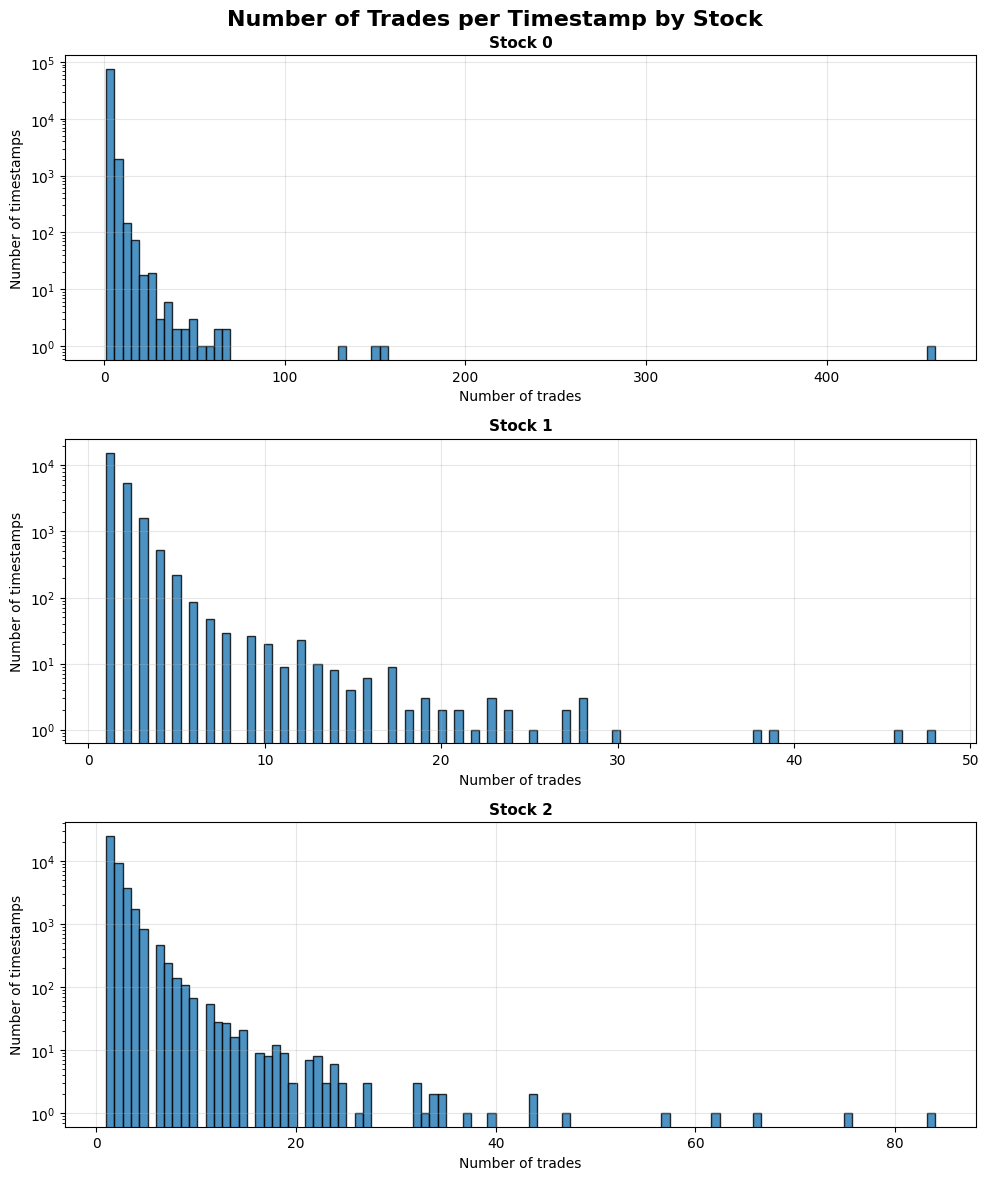

In [ ]:
df_unique = df.copy()

df_unique['cashflow'] = df_unique['price'] * df_unique['qty']
df_unique['total_volume'] = df_unique.groupby(['stock','ts'])['qty'].transform('sum')
df_unique['q_weighted_price'] = df_unique.groupby(['stock','ts'])['cashflow'].transform('sum') / df_unique['total_volume']
df_unique['n_trades'] = df_unique.groupby(['stock','ts'])['qty'].transform('count')
df_unique = df_unique.sort_values(['stock','ts']).groupby(['stock','ts']).last().reset_index()
df_unique['qty'] = df_unique['total_volume']
df_unique['price'] = df_unique['q_weighted_price']

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Number of Trades per Timestamp by Stock', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df_unique['stock'].unique())):
    ax = axes[idx]
    stock_data = df_unique[df_unique['stock'] == stock]['n_trades']
    ax.hist(stock_data, bins=100, alpha=0.8, edgecolor='black')
    ax.set_yscale('log')
    ax.set_ylabel('Number of timestamps', fontsize=10)
    ax.set_xlabel('Number of trades', fontsize=10)
    ax.set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Price Statistics (by stock and day)

                mean       std     min     max  count  median
stock day                                                    
0     0    55.430137  0.165443  54.840  55.740  19076  55.420
      1    55.476423  0.161049  55.150  55.780  21933  55.470
      2    56.216857  0.189988  55.810  56.640  30315  56.190
      3    56.436704  0.401453  55.760  57.410  32581  56.370
      4    55.074316  0.276714  54.530  55.940  40058  55.100
1     0    26.511555  0.183140  26.030  26.845   4927  26.490
      1    26.373156  0.138449  26.125  26.680   5941  26.385
      2    27.426387  0.244204  26.545  27.815  10144  27.475
      3    27.347645  0.150161  26.975  27.770   8038  27.360
      4    26.778918  0.222375  26.305  27.465   8472  26.800
2     0    53.502551  0.181884  52.910  53.850   9500  53.510
      1    52.559478  0.224050  52.150  53.180  11466  52.500
      2    51.914382  0.146808  51.480  52.320  13178  51.920
      3    51.730347  0.461979  5

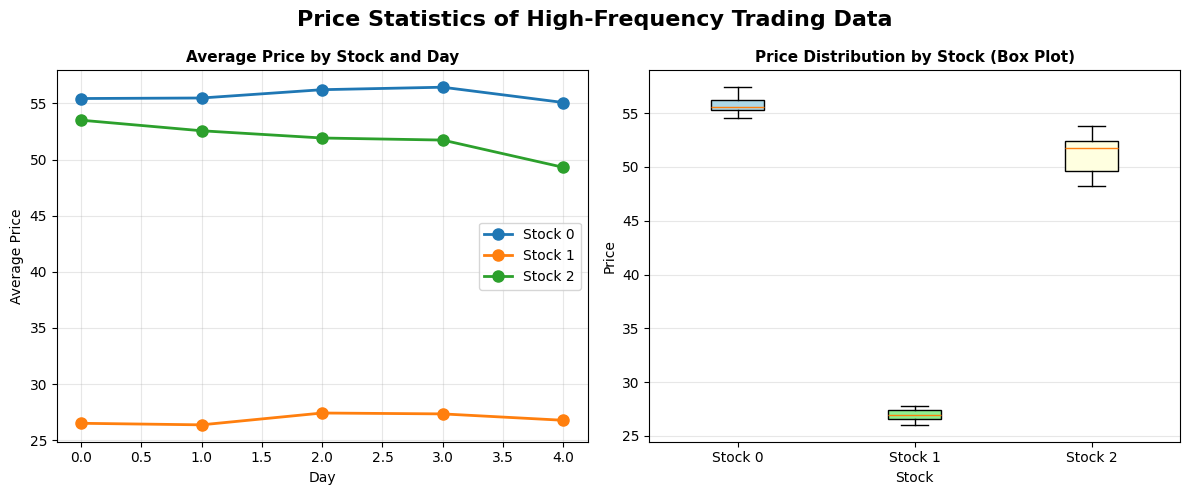

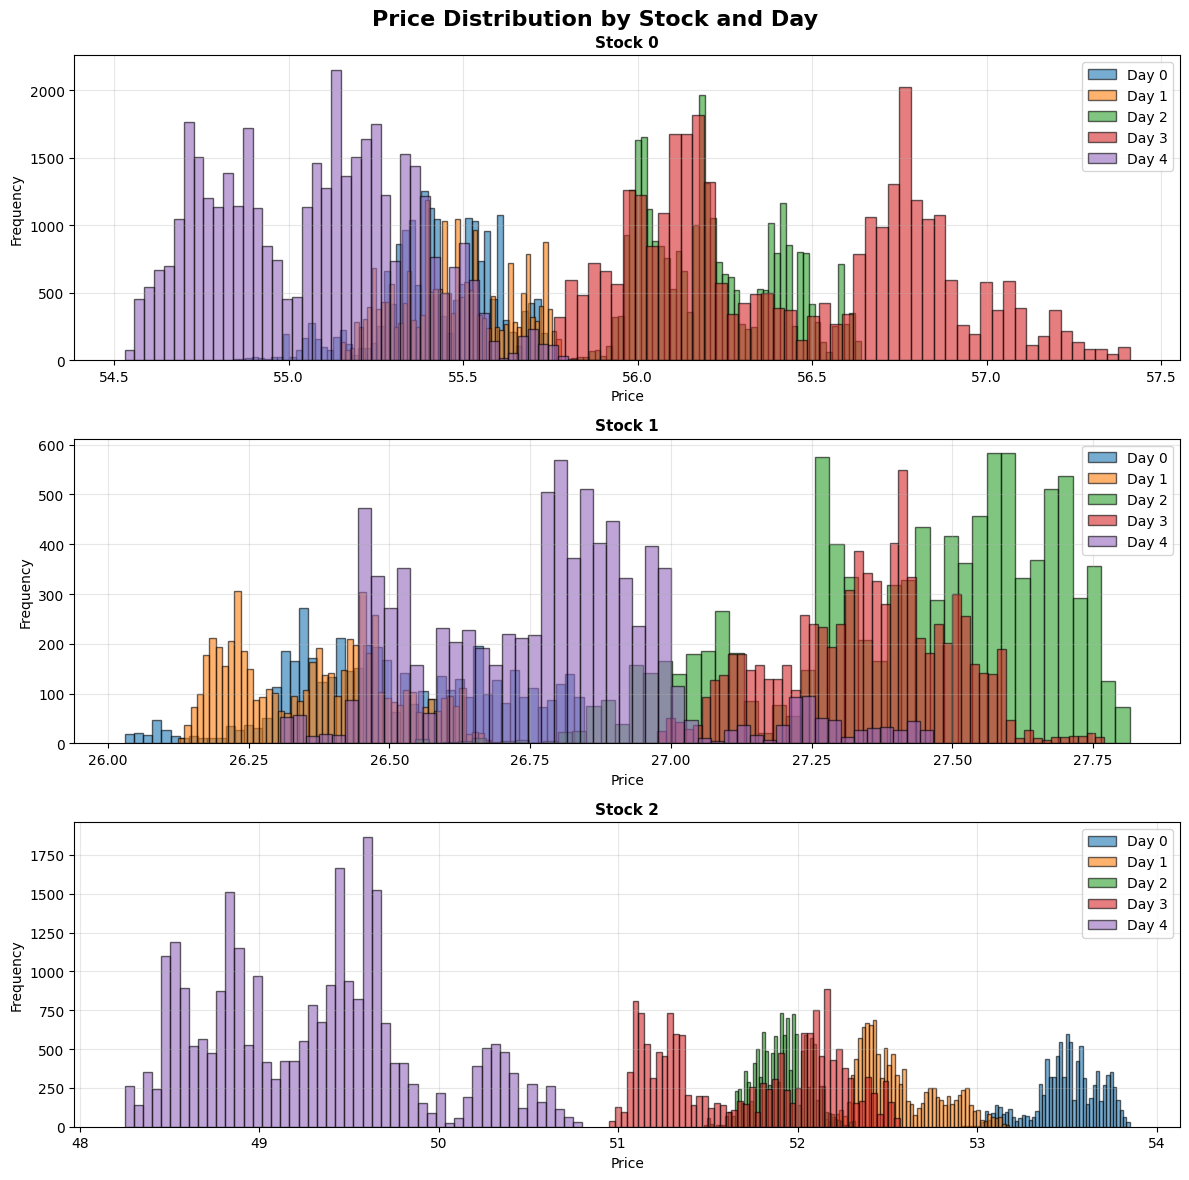

In [85]:
# Price statistics
print("Price Statistics (by stock and day)\n")
price_stats = df.groupby(['stock', 'day'])['price'].agg(['mean', 'std', 'min', 'max', 'count', 'median'])
print(price_stats)

# Figure 1: Average price and box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Price Statistics of High-Frequency Trading Data', fontsize=16, fontweight='bold')

ax = axes[0]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].groupby('day')['price'].mean()
    ax.plot(stock_data.index, stock_data.values, marker='o', linewidth=2, 
            markersize=8, label=f'Stock {stock}')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Average Price', fontsize=10)
ax.set_title('Average Price by Stock and Day', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
box_data = [df[df['stock'] == stock]['price'].values for stock in sorted(df['stock'].unique())]
bp = ax.boxplot(box_data, tick_labels=[f'Stock {i}' for i in sorted(df['stock'].unique())],
                patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightyellow']):
    patch.set_facecolor(color)
ax.set_xlabel('Stock', fontsize=10)
ax.set_ylabel('Price', fontsize=10)
ax.set_title('Price Distribution by Stock (Box Plot)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Figure 2: Price distribution per stock showing all 5 days separately
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Price Distribution by Stock and Day', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df['stock'].unique())):
    ax = axes[idx]
    for day in sorted(df['day'].unique()):
        stock_day_data = df[(df['stock'] == stock) & (df['day'] == day)]['price']
        ax.hist(stock_day_data, bins=50, alpha=0.6, label=f'Day {day}', edgecolor='black')
    ax.set_xlabel('Price', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Looking at the price, we see that stock 0 (the most traded stock as seen in the previous figure) is also the one with the highest average price, once again followed by stock 2 and then stock 1. Stock 2, as can be seen in the box plot, presents a much wider standard deviation than the other two stocks. This is notably noticeable for days 3 and 4, where the standard deviation increases drastically from day 2 (0.15 to 0.46 from days 2 to 3). The increase in the standard deviation from days 2 to 3 is also observed for stock 0, though it decreases again on day 4. This is accompagnied with a decrease in the average price for both stocks from days 3 to 4. On the other hand, stock 1's standard deviation decreases from day 2 to day 3, while its average price remains relatively stable across the 5 days.

Quantity Statistics (by stock and days)
                 mean         std  min    max  count  median
stock day                                                   
0     0    134.961260  231.604595    1  11400  19076   114.0
      1    111.681348  174.119529    1   8500  21933   100.0
      2    143.365727  220.002988    1   9042  30315   106.0
      3    128.032135  263.771218    1  19054  32581   103.0
      4    126.367567  182.971099    1  12417  40058   103.0
1     0    103.649077  233.594998    1  12031   4927    53.0
      1    105.819896  270.430813    1  16153   5941    63.0
      2    153.352228  606.935835    1  47478  10144    80.0
      3    129.804802  170.915010    1   6792   8038    89.0
      4    125.352101  156.100807    1   5401   8472    82.0
2     0    104.861474  269.699381    1  14203   9500    81.5
      1    105.634048  195.306684    1   8871  11466    95.0
      2    115.553574  237.158613    1  13197  13178   100.0
      3    112.878352  264.987249    1  15000

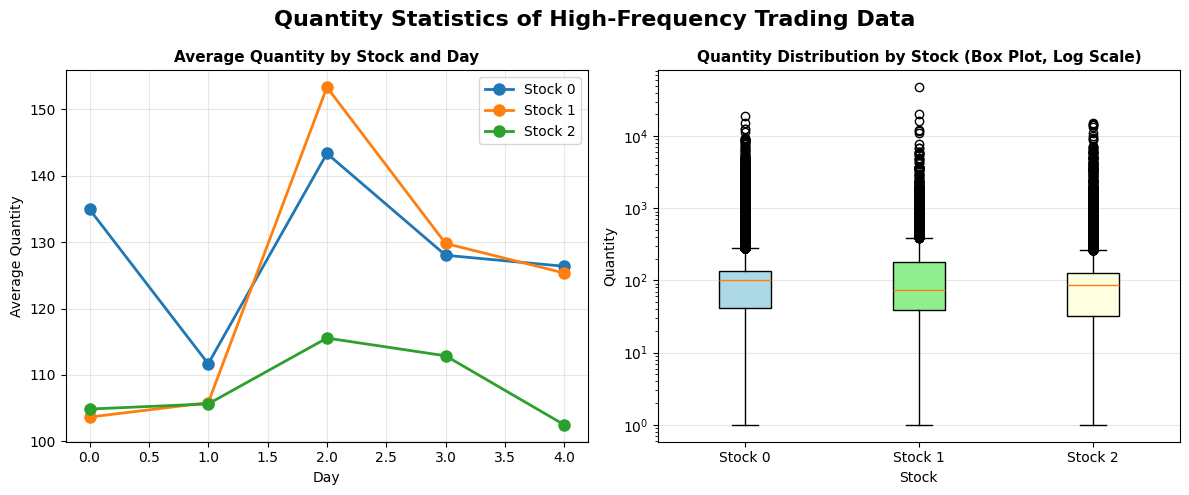

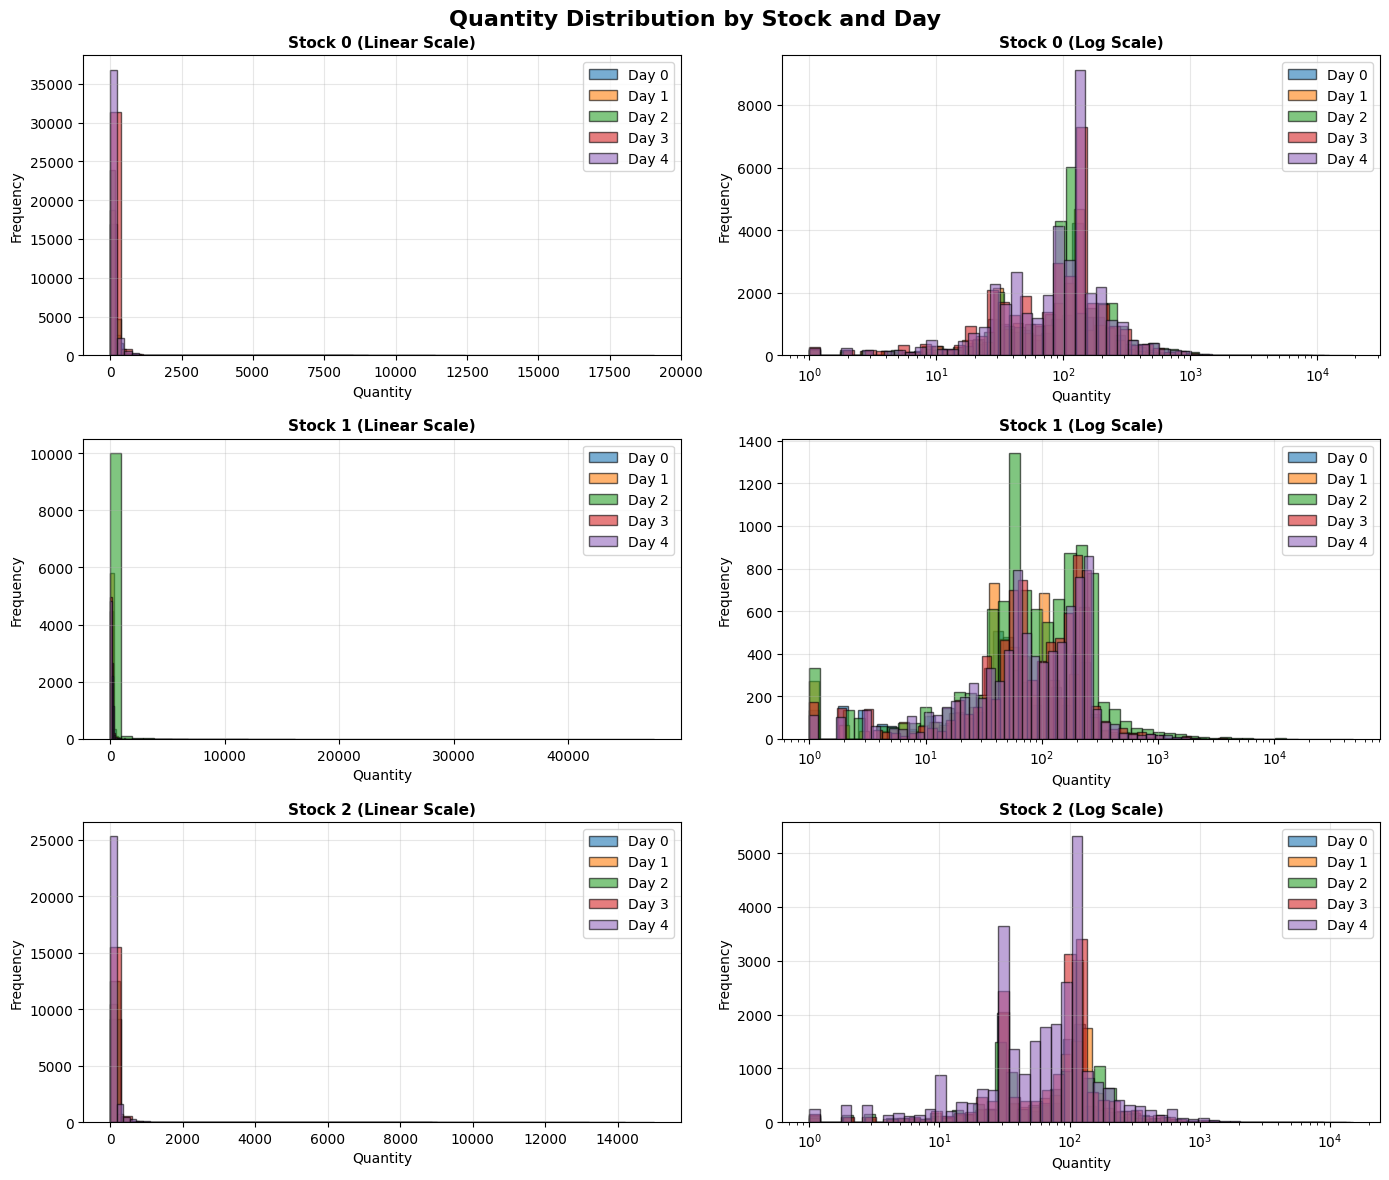

In [86]:
# Quantity statistics
print("Quantity Statistics (by stock and days)")
qty_stats = df.groupby(['stock', 'day'])['qty'].agg(['mean', 'std', 'min', 'max', 'count', 'median'])
print(qty_stats)

# Figure 1: Average quantity and box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Quantity Statistics of High-Frequency Trading Data', fontsize=16, fontweight='bold')

# Average Quantity by stock and day
ax = axes[0]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].groupby('day')['qty'].mean()
    ax.plot(stock_data.index, stock_data.values, marker='o', linewidth=2, 
            markersize=8, label=f'Stock {stock}')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Average Quantity', fontsize=10)
ax.set_title('Average Quantity by Stock and Day', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Quantity Box Plot
ax = axes[1]
box_data = [df[df['stock'] == stock]['qty'].values for stock in sorted(df['stock'].unique())]
bp = ax.boxplot(box_data, tick_labels=[f'Stock {i}' for i in sorted(df['stock'].unique())],
                patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightyellow']):
    patch.set_facecolor(color)
ax.set_xlabel('Stock', fontsize=10)
ax.set_ylabel('Quantity', fontsize=10)
ax.set_yscale('log')
ax.set_title('Quantity Distribution by Stock (Box Plot, Log Scale)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Figure 2: Quantity distribution per stock showing all 5 days separately
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Quantity Distribution by Stock and Day', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df['stock'].unique())):
    # Linear scale
    ax = axes[idx, 0]
    for day in sorted(df['day'].unique()):
        stock_day_data = df[(df['stock'] == stock) & (df['day'] == day)]['qty']
        ax.hist(stock_day_data, bins=50, alpha=0.6, label=f'Day {day}', edgecolor='black')
    ax.set_xlabel('Quantity', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Stock {stock} (Linear Scale)', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Log scale
    ax = axes[idx, 1]
    for day in sorted(df['day'].unique()):
        stock_day_data = df[(df['stock'] == stock) & (df['day'] == day)]['qty']
        logbins = np.logspace(0, np.log10(stock_day_data.max()), 50)
        ax.hist(stock_day_data, bins=logbins, alpha=0.6, label=f'Day {day}', edgecolor='black')
    ax.set_xlabel('Quantity', fontsize=10)
    ax.set_xscale('log')
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Stock {stock} (Log Scale)', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Quantity-wise, all three stocks show an increase in the average quantity traded from days 1 to 2, with an increase in the standard deviation as well. The stocks then gradually decrease in average quantity.

Time Between Trades (seconds, by stock and day)

               mean        std  min         max
stock day                                      
0     0    1.602709   5.077909  0.0   91.165176
      1    1.394177   3.643801  0.0   64.729272
      2    1.008530   3.221090  0.0   65.223742
      3    0.938800   2.748858  0.0   50.840068
      4    0.763316   2.387479  0.0   55.326091
1     0    6.200891  15.576144  0.0  187.605045
      1    5.147310  13.348794  0.0  172.933748
      2    3.014192   7.801286  0.0   96.107265
      3    3.806845   9.135749  0.0  128.782453
      4    3.610261   8.984181  0.0  134.572186
2     0    3.217923   8.963964  0.0  152.525032
      1    2.666405   6.547779  0.0   70.779818
      2    2.321306   5.667337  0.0   71.940200
      3    1.888965   4.853981  0.0   97.189989
      4    1.096931   2.875541  0.0   52.994861


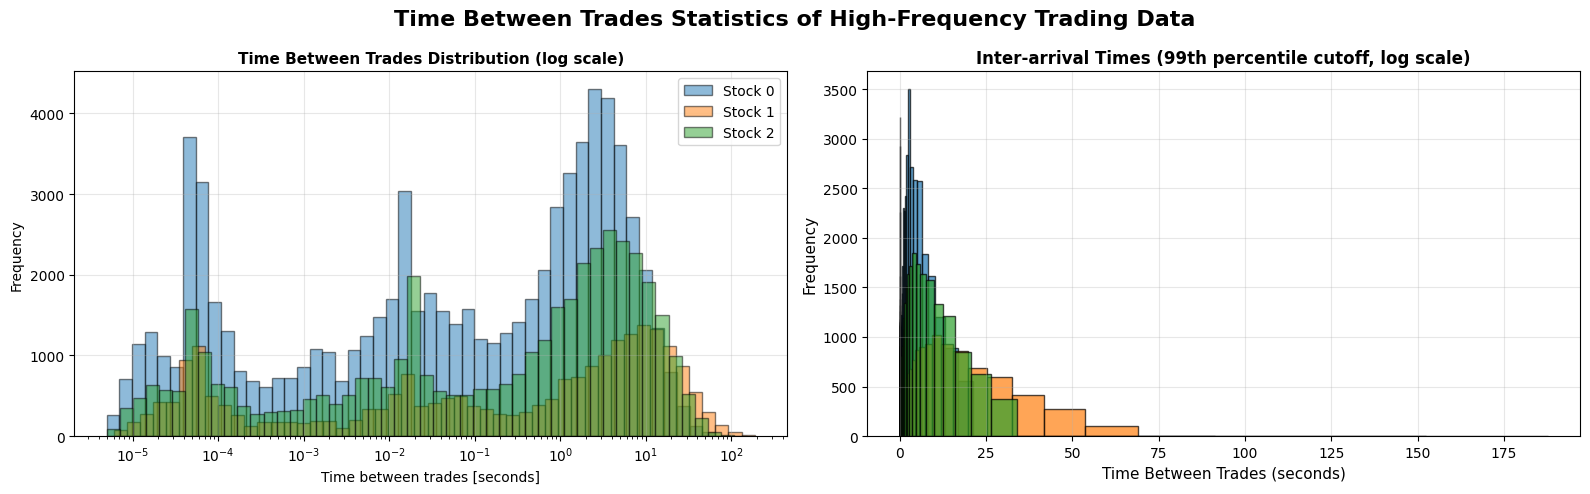

In [40]:
# Time between trades statistics
print("Time Between Trades (seconds, by stock and day)\n")
dt_stats = df.groupby(['stock', 'day'])['dt'].agg(['mean', 'std', 'min', 'max'])
print(dt_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Time Between Trades Statistics of High-Frequency Trading Data', fontsize=16, fontweight='bold')

ax = axes[0]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock]['dt'].dropna()
    stock_data = stock_data[stock_data > 0]
    logbins = np.logspace(np.log10(stock_data.min()), np.log10(stock_data.max()), 50)
    ax.hist(stock_data, bins=logbins, alpha=0.5, label=f'Stock {stock}', edgecolor='black')
ax.set_xscale('log')
ax.set_xlabel('Time between trades [seconds]', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title('Time Between Trades Distribution (log scale)', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Inter-arrival times distribution (time between trades)
ax = axes[1]
dt_data = df['dt'].dropna()
dt_data = dt_data[dt_data > 0]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock]['dt'].dropna()
    stock_data = stock_data[stock_data > 0] 
    logbins = np.logspace(np.log10(stock_data.min()), np.log10(stock_data.max()), 70)
    ax.hist(stock_data[stock_data < stock_data.quantile(0.99)], bins=logbins, alpha=0.7, 
        label=f'Stock {stock}', edgecolor='black')
ax.set_xlabel('Time Between Trades (seconds)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Inter-arrival Times (99th percentile cutoff, log scale)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Across all three stocks, stock 0 has the lowest average time between trades, and stock 1 has the highest. This is consistent with the fact that stock 0 is the most traded, while stock 1 is the least traded. The average time between trades decreases progressively for all three stocks, which is consistent with the increase in total trades observed in the first figure. 

Turnover (by stock and day)



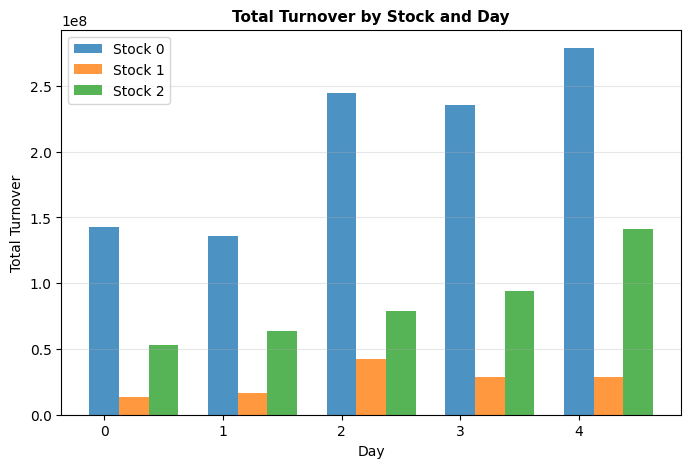

In [41]:
# Turnover statistics
print("Turnover (by stock and day)\n")
turnover = df.groupby(['stock', 'day'])['turnover'].sum()

plt.figure(figsize=(8, 5))

for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].groupby('day')['turnover'].sum()
    plt.bar(stock_data.index + stock * 0.25, stock_data.values, width=0.25, 
           label=f'Stock {stock}', alpha=0.8)
plt.xlabel('Day', fontsize=10)
plt.ylabel('Total Turnover', fontsize=10)
plt.title('Total Turnover by Stock and Day', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.show()

The turnover is the product of the price and quantity. The results in the figure above are consistent with the previous analyses. Stock 0 has the highest average turnover, followed by stock 2 and then stock 1. The increase and decrease patterns of the average turnover follow the patterns observed in the price and quantity analyses.

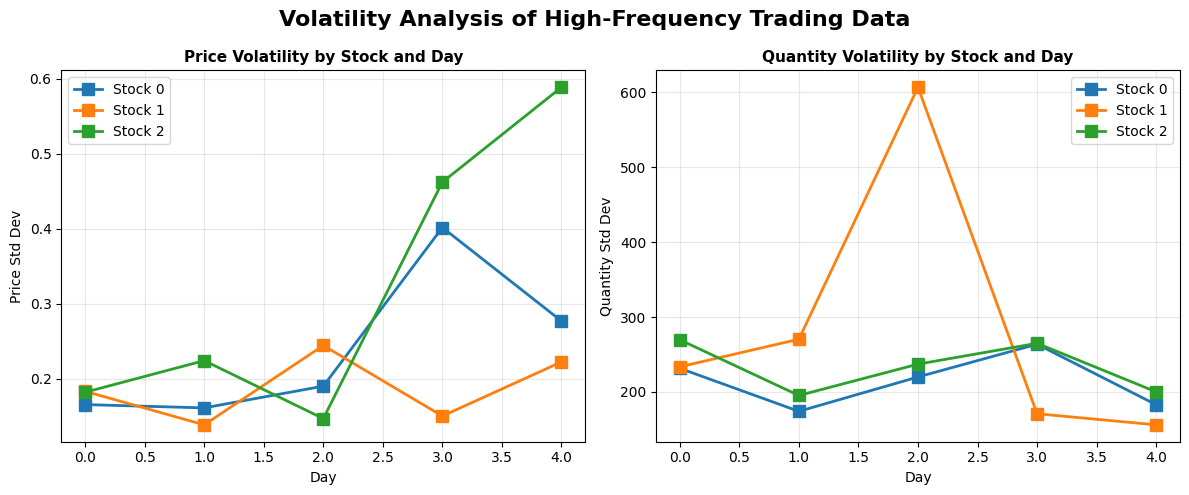

In [42]:
# Volatility analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Volatility Analysis of High-Frequency Trading Data', fontsize=16, fontweight='bold')

# Price volatility (std) by stock and day
ax = axes[0]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].groupby('day')['price'].std()
    ax.plot(stock_data.index, stock_data.values, marker='s', linewidth=2, 
            markersize=8, label=f'Stock {stock}')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Price Std Dev', fontsize=10)
ax.set_title('Price Volatility by Stock and Day', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Quantity volatility (std) by stock and day
ax = axes[1]
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].groupby('day')['qty'].std()
    ax.plot(stock_data.index, stock_data.values, marker='s', linewidth=2, 
            markersize=8, label=f'Stock {stock}')
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Quantity Std Dev', fontsize=10)
ax.set_title('Quantity Volatility by Stock and Day', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This is a dedicated look at the price and quantity volatility of each stock, which confirms previous observations.  

Trading Activity Metrics
Average trades per stock per day: 17312.93
Std dev of trades per stock per day: 10913.65
Min trades (stock-day): 4927
Max trades (stock-day): 40058
Trading Time Span:
Stock 0, Day 0: 09:00:27 to 17:29:58 (8.49 hours)
Stock 0, Day 1: 09:00:16 to 17:29:53 (8.49 hours)
Stock 0, Day 2: 09:00:23 to 17:29:56 (8.49 hours)
Stock 0, Day 3: 09:00:13 to 17:29:59 (8.50 hours)
Stock 0, Day 4: 09:00:23 to 17:29:59 (8.49 hours)
Stock 1, Day 0: 09:00:48 to 17:29:53 (8.48 hours)
Stock 1, Day 1: 09:00:17 to 17:29:52 (8.49 hours)
Stock 1, Day 2: 09:00:20 to 17:29:53 (8.49 hours)
Stock 1, Day 3: 09:00:00 to 17:29:56 (8.50 hours)
Stock 1, Day 4: 09:00:11 to 17:29:54 (8.50 hours)
Stock 2, Day 0: 09:00:26 to 17:29:53 (8.49 hours)
Stock 2, Day 1: 09:00:29 to 17:29:59 (8.49 hours)
Stock 2, Day 2: 09:00:10 to 17:29:58 (8.50 hours)
Stock 2, Day 3: 09:00:25 to 17:29:58 (8.49 hours)
Stock 2, Day 4: 09:00:19 to 17:30:00 (8.49 hours)


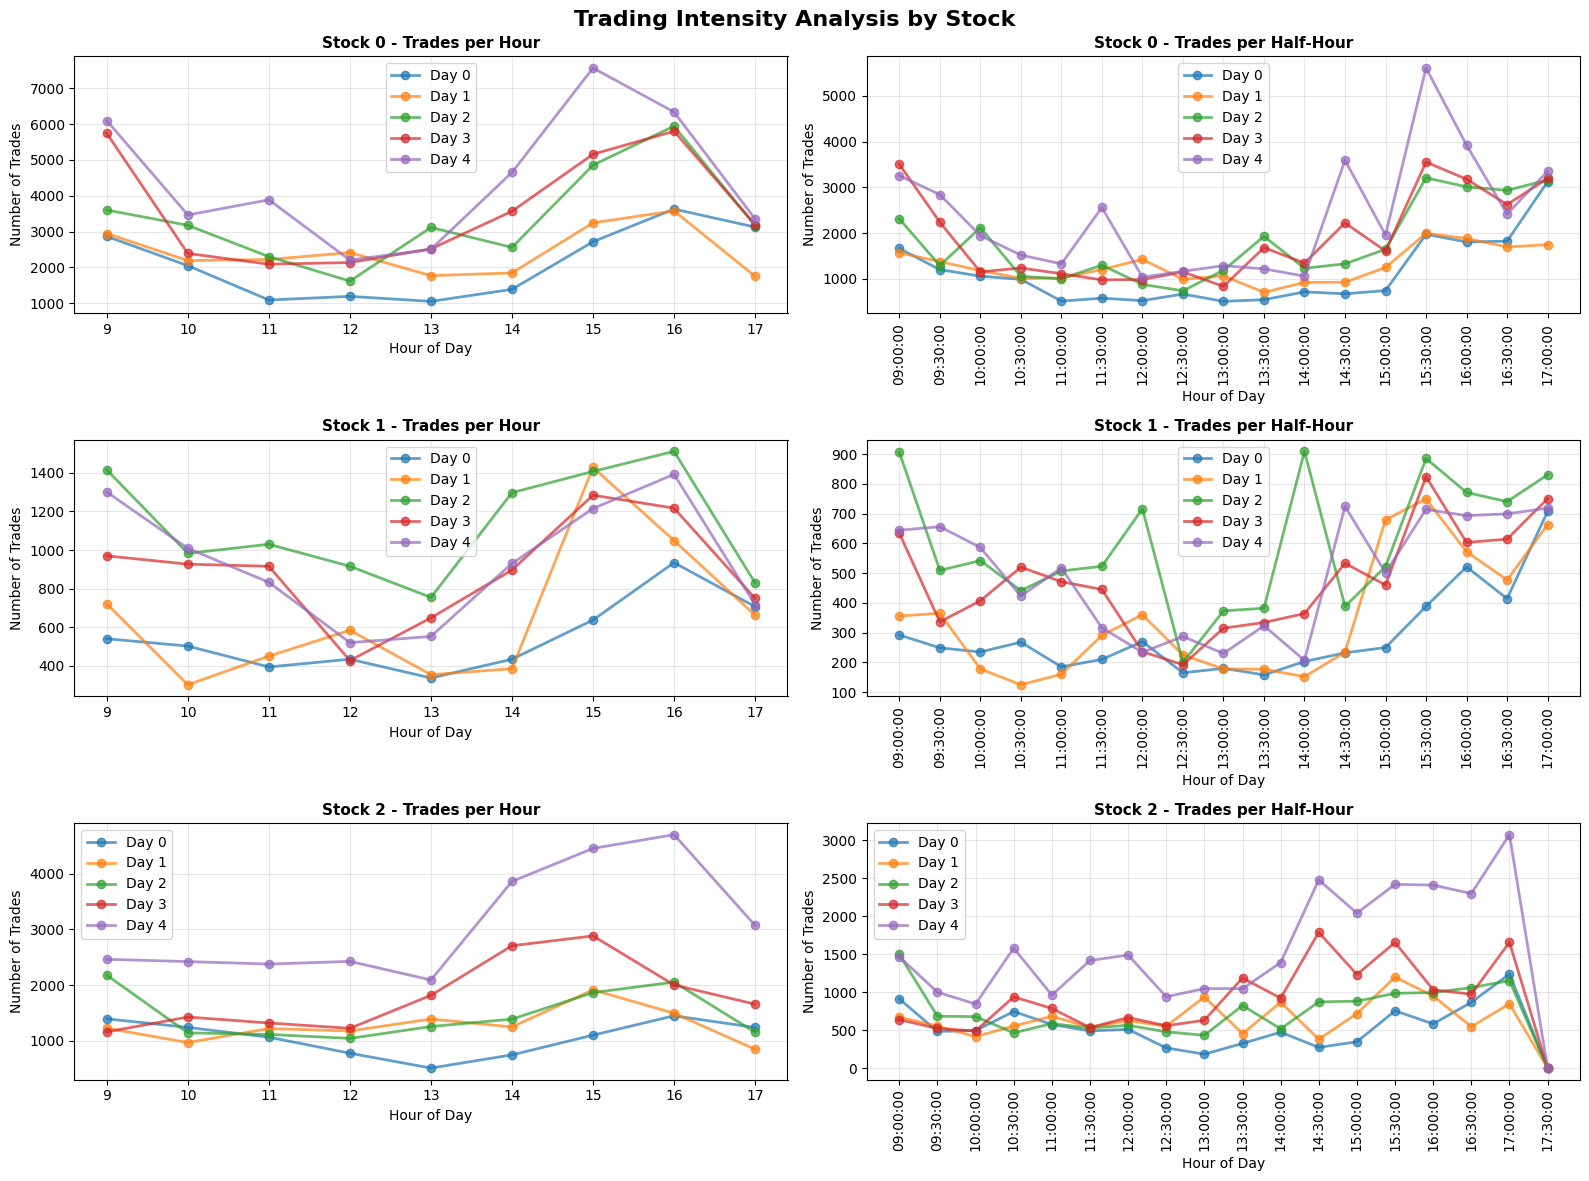

In [43]:
# Trading intensity analysis

# Trading activity metrics
print("Trading Activity Metrics")
trades_per_stock_day = df.groupby(['stock', 'day']).size()
print(f"Average trades per stock per day: {trades_per_stock_day.mean():.2f}")
print(f"Std dev of trades per stock per day: {trades_per_stock_day.std():.2f}")
print(f"Min trades (stock-day): {trades_per_stock_day.min()}")
print(f"Max trades (stock-day): {trades_per_stock_day.max()}")


# Trading Time Span
print("Trading Time Span:")
for stock in sorted(df['stock'].unique()):
    for day in sorted(df['day'].unique()):
        subset = df[(df['stock'] == stock) & (df['day'] == day)]
        if len(subset) > 0:
            start_time = subset['ts'].min()
            end_time = subset['ts'].max()
            duration = (end_time - start_time).total_seconds() / 3600  # hours
            print(f"Stock {stock}, Day {day}: {start_time.strftime('%H:%M:%S')} to {end_time.strftime('%H:%M:%S')} ({duration:.2f} hours)")


# Compute time features
df['hour'] = df['ts'].dt.hour
df['30'] = df['ts'].dt.floor('30min').dt.time

# Create figure with all stocks
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Trading Intensity Analysis by Stock', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df['stock'].unique())):
    stock_df = df[df['stock'] == stock]
    
    # Trading intensity over time (trades per hour for each day)
    ax = axes[idx, 0]
    hourly_trades = stock_df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    for day in hourly_trades.index:
        ax.plot(hourly_trades.columns, hourly_trades.loc[day], 
                marker='o', linewidth=2, markersize=6, label=f'Day {day}', alpha=0.7)
    ax.set_xlabel('Hour of Day', fontsize=10)
    ax.set_ylabel('Number of Trades', fontsize=10)
    ax.set_title(f'Stock {stock} - Trades per Hour', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Trading intensity over time (trades per half-hour for each day)
    ax = axes[idx, 1]
    halfhour_trades = stock_df.groupby(['day', '30']).size().unstack(fill_value=0)
    for day in halfhour_trades.index:
        x_values = [str(t) for t in halfhour_trades.columns] 
        y_values = halfhour_trades.loc[day]
        ax.plot(x_values, y_values, 
                marker='o', linewidth=2, markersize=6, label=f'Day {day}', alpha=0.7)
    ax.set_xlabel('Hour of Day', fontsize=10)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Number of Trades', fontsize=10)
    ax.set_title(f'Stock {stock} - Trades per Half-Hour', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The trading intensity, when looking at trades per hour, following approximately the same pattern for all three stocks across the five days. A gradual decrease in trading intensity is observed from the start of the trading day until around 1pm, followed by a gradual increase until 4pm and a steep drop at the end of the trading day. This pattern is consistent with typical intraday trading behaviors, where activity tends to be higher at the market open and close.

The half-hour graphs show this same pattern but with more granularity. We see a slight peak around 11:30am, a peak around 2pm, another around 3pm, and then the drop.

In [44]:
# Correlation analysis per stock
print("Correlation Matrix by Stock\n")
correlation_cols = ['price', 'qty', 'dt', 'turnover']

for idx, stock in enumerate(sorted(df['stock'].unique())):
    stock_df = df[df['stock'] == stock]
    corr_matrix = stock_df[correlation_cols].corr()
    
    print(f"Stock {stock}:")
    print(corr_matrix)

Correlation Matrix by Stock

Stock 0:
             price       qty        dt  turnover
price     1.000000  0.018007  0.006937  0.024534
qty       0.018007  1.000000 -0.020842  0.999914
dt        0.006937 -0.020842  1.000000 -0.020787
turnover  0.024534  0.999914 -0.020787  1.000000
Stock 1:
             price       qty        dt  turnover
price     1.000000  0.034835 -0.067567  0.040860
qty       0.034835  1.000000 -0.039043  0.999895
dt       -0.067567 -0.039043  1.000000 -0.039350
turnover  0.040860  0.999895 -0.039350  1.000000
Stock 2:
             price       qty        dt  turnover
price     1.000000  0.007435  0.145041  0.021388
qty       0.007435  1.000000 -0.043834  0.999475
dt        0.145041 -0.043834  1.000000 -0.042287
turnover  0.021388  0.999475 -0.042287  1.000000


The correlation matrix appears to show little to no correlation between the different variables (price, quantity, time between trades) for all three stocks. We do observe the correlation between price, quantity and turnover, which is expected since turnover is calculated as the product of price and quantity.

In [45]:
# Distribution characteristics per stock
print("Skewness and Kurtosis by Stock:\n")
for stock in sorted(df['stock'].unique()):
    print(f"Stock {stock}:")
    stock_df = df[df['stock'] == stock]
    for col in ['price', 'qty', 'dt', 'turnover']:
        data = stock_df[col].dropna()
        skew = stats.skew(data)
        kurt = stats.kurtosis(data)
        print(f"  {col:15s} - Skewness: {skew:8.3f}, Kurtosis: {kurt:8.3f}")
    print()

Skewness and Kurtosis by Stock:

Stock 0:
  price           - Skewness:    0.267, Kurtosis:   -0.722
  qty             - Skewness:   22.988, Kurtosis: 1094.702
  dt              - Skewness:    6.524, Kurtosis:   67.656
  turnover        - Skewness:   23.121, Kurtosis: 1112.181

Stock 1:
  price           - Skewness:   -0.069, Kurtosis:   -1.317
  qty             - Skewness:   71.987, Kurtosis: 8339.914
  dt              - Skewness:    5.060, Kurtosis:   38.757
  turnover        - Skewness:   71.572, Kurtosis: 8277.549

Stock 2:
  price           - Skewness:   -0.320, Kurtosis:   -1.175
  qty             - Skewness:   27.857, Kurtosis: 1295.394
  dt              - Skewness:    5.462, Kurtosis:   48.890
  turnover        - Skewness:   28.211, Kurtosis: 1327.067



The skewness and kurtosis values indicate that the price distributions for stock 0 is slightly right skewed (positive skewness) with negative kurtosis, suggesting a lighter tail than a normal distribution. Stocks 1 and 2 show negative skewness, indicating a left-skewed distribution, with stock 2 having a more pronounced left skew. Both stocks 1 and 2 also exhibit negative kurtosis.

The skewness for all three stocks is much more pronounced when looking at quantity, with all three showing positive skewness and positive kurtosis, indicating a distribution with a heavier right tail.

The time between trades shows high positive skewness for all three stocks, with stock 1 having the highest skewness value. This indicates that while most trades occur within a short time frame, there are occasional long gaps between trades. The kurtosis values are also high and positive, suggesting a distribution with heavy tails.

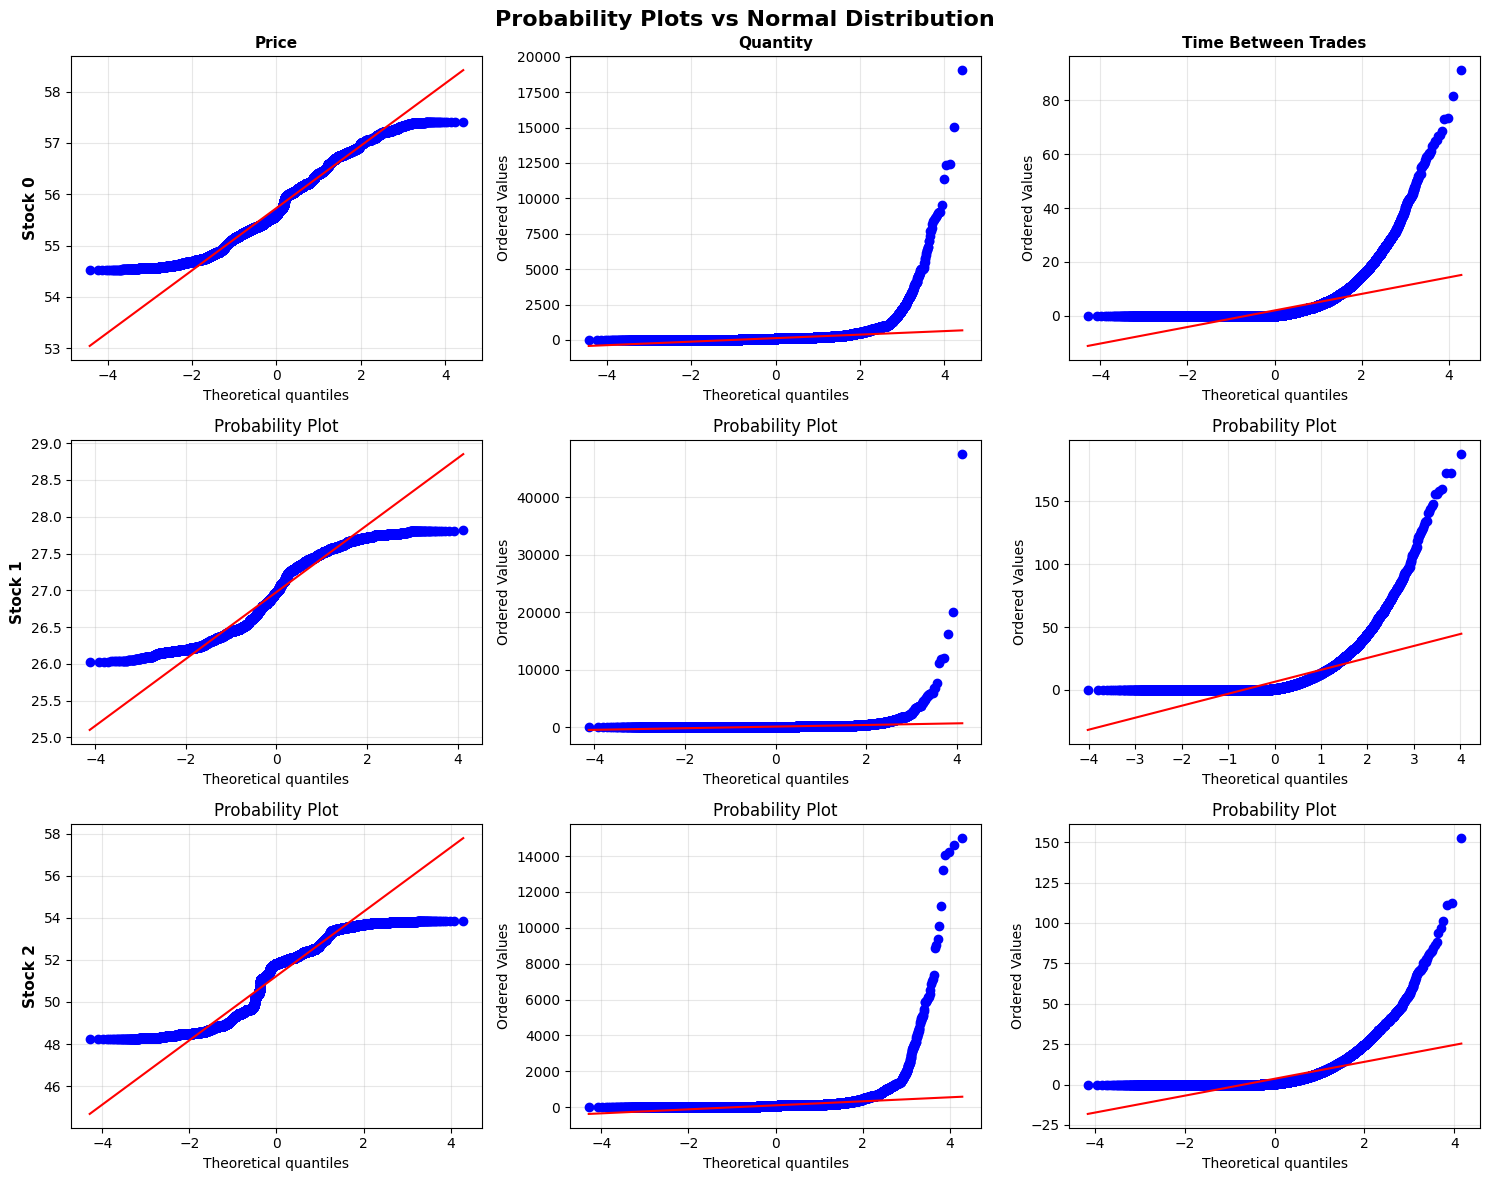

In [46]:
# Probability plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Probability Plots vs Normal Distribution', fontsize=16, fontweight='bold')

variables = ['price', 'qty', 'dt']
var_labels = ['Price', 'Quantity', 'Time Between Trades']

for row, stock in enumerate(sorted(df['stock'].unique())):
    stock_data = df[df['stock'] == stock]
    for col, (var, label) in enumerate(zip(variables, var_labels)):
        ax = axes[row, col]
        data = stock_data[var].dropna()
        if var == 'dt':
            data = data[data > 0]  # Remove zeros for dt
        stats.probplot(data, dist="norm", plot=ax)
        if row == 0:
            ax.set_title(f'{label}', fontsize=11, fontweight='bold')
        if col == 0:
            ax.set_ylabel(f'Stock {stock}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The probability plots (not to be confused with Q-Q plots) illustrate the distribution characteristics of the price, quantity, and time between trades for each stock. 

The deviations from the reference line in these plots confirm the skewness and kurtosis observations made earlier. 

For instance, the price distributions of all three stocks show significant deviations from normality, consistent with their skewness and kurtosis values. Similarly, the quantity and time between trades plots exhibit patterns that align with their respective skewness and kurtosis metrics, indicating non-normal distributions with heavier tails.

---
### 1.2 Tick sizes: Measurement

The tick size is the minimum price increment at which a security can trade. We measure this by analyzing the distribution of price differences and the granularity of price levels.

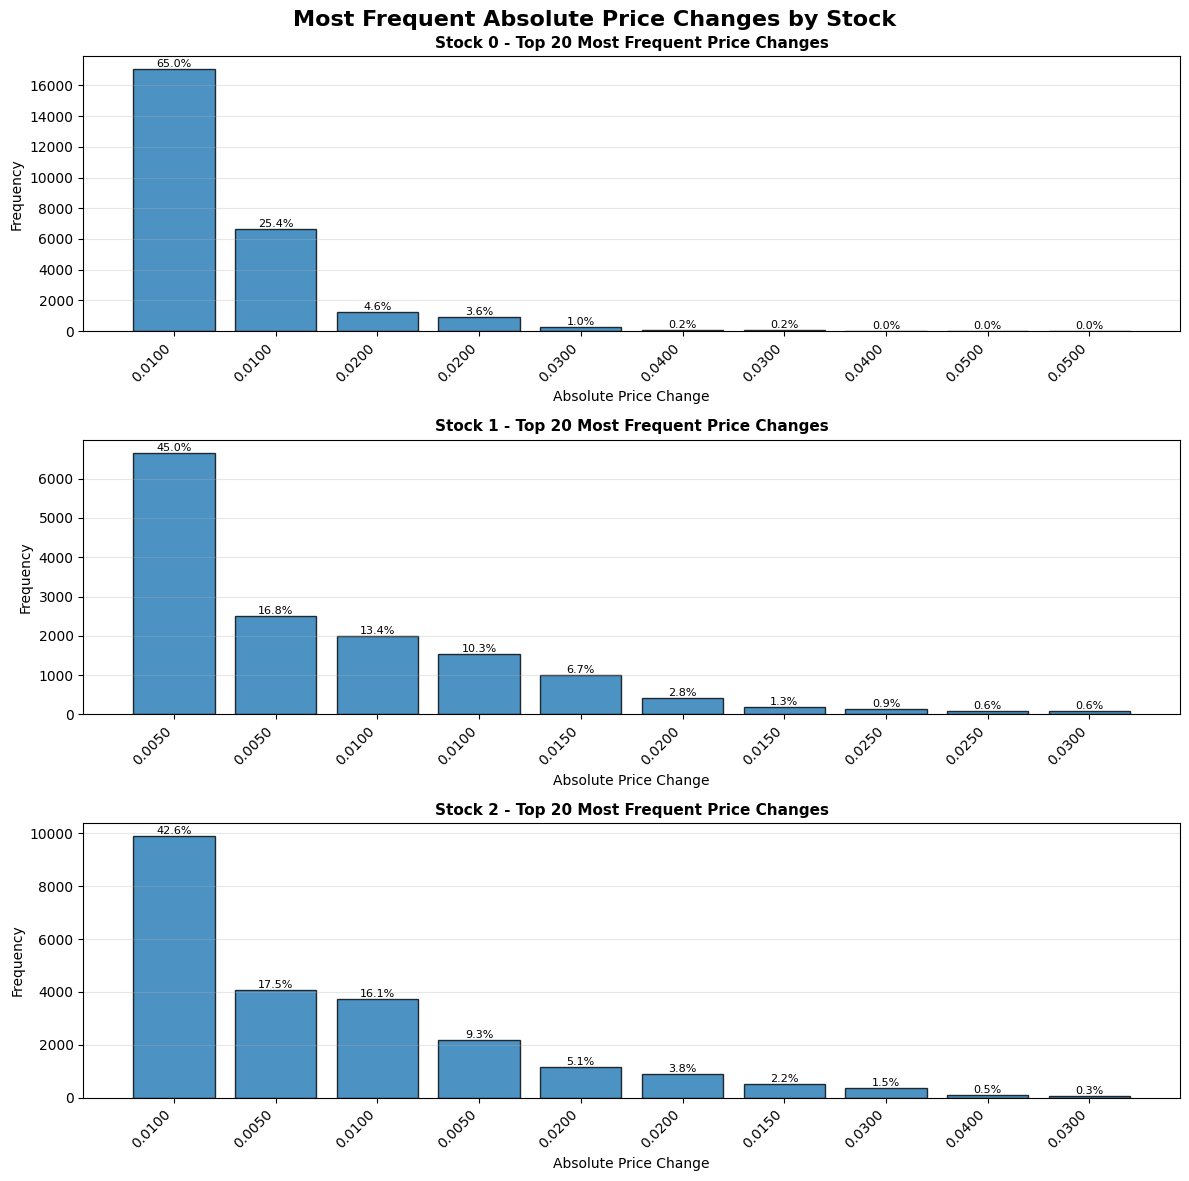

count      mean       std    min    25%    50%   75%    max
stock day                                                               
0     0     2834.0  0.010974  0.003610  0.010  0.010  0.010  0.01  0.050
      1     3823.0  0.011038  0.003800  0.010  0.010  0.010  0.01  0.050
      2     4418.0  0.010706  0.003149  0.010  0.010  0.010  0.01  0.090
      3     6846.0  0.011207  0.003910  0.010  0.010  0.010  0.01  0.080
      4     8308.0  0.011472  0.004417  0.010  0.010  0.010  0.01  0.090
1     0     1910.0  0.007628  0.005731  0.005  0.005  0.005  0.01  0.075
      1     2665.0  0.008165  0.006301  0.005  0.005  0.005  0.01  0.145
      2     3424.0  0.007798  0.005243  0.005  0.005  0.005  0.01  0.075
      3     3366.0  0.008948  0.006845  0.005  0.005  0.005  0.01  0.105
      4     3446.0  0.008861  0.006211  0.005  0.005  0.005  0.01  0.055
2     0     2255.0  0.011774  0.005399  0.010  0.010  0.010  0.01  0.060
      1     2939.0  0.012106  0.005682  0.010  0.010  0.010  0.01  0.100
      2     3164.0  0.011678  0.004985  0.010  0.010  0.010  0.01  0.100
      3     4581.0  0.012467  0.006113  0.010  0.010  0.010  0.01  0.100
      4    10256.0  0.008283  0.005845  0.005  0.005  0.005  0.01  0.070

In [91]:
# Calculate price changes (differences) for each stock-day pair
df_sorted = df.sort_values(['stock', 'day', 'ts'])
df_sorted['price_change'] = df_sorted.groupby(['stock', 'day'])['price'].diff()

# Get absolute non-zero price changes
tick_sizes = {}
for stock in sorted(df['stock'].unique()):
    stock_data = df_sorted[df_sorted['stock'] == stock]['price_change']
    # Remove NaN and zero changes
    non_zero_changes = stock_data[stock_data != 0].abs().dropna()
    
    if len(non_zero_changes) > 0:
        # The tick size is the minimum price change
        min_change = non_zero_changes.min()
        
        # Find the most common price change (mode)
        from scipy import stats as sp_stats
        mode_result = sp_stats.mode(non_zero_changes, keepdims=True)
        mode_change = mode_result.mode[0]
        
        # Check if there's a clear tick size pattern
        # by looking at the distribution of price changes
        unique_changes = non_zero_changes.value_counts().head(10)
        
        tick_sizes[stock] = {
            'min': min_change,
            'mode': mode_change,
            'mean': non_zero_changes.mean(),
            'median': non_zero_changes.median(),
            'std': non_zero_changes.std(),
            'count': len(non_zero_changes),
            'top_changes': unique_changes
        }

# Visualize most frequent absolute price changes
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Most Frequent Absolute Price Changes by Stock', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df['stock'].unique())):
    ax = axes[idx]
    top_changes = tick_sizes[stock]['top_changes'].head(20)
    
    # Create bar chart
    x_pos = np.arange(len(top_changes))
    ax.bar(x_pos, top_changes.values, alpha=0.8, edgecolor='black')
    ax.set_xlabel('Absolute Price Change', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Stock {stock} - Top 20 Most Frequent Price Changes', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{x:.4f}' for x in top_changes.index], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for i, (change, count) in enumerate(zip(top_changes.index, top_changes.values)):
        pct = count / tick_sizes[stock]['count'] * 100
        ax.text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# Statistics table per stock per day
df['price_diff'] = df.groupby(['stock', 'day'])['price'].diff().abs()
df[df['price_diff'] != 0]['price_diff'].groupby([df['stock'],df['day']]).describe()

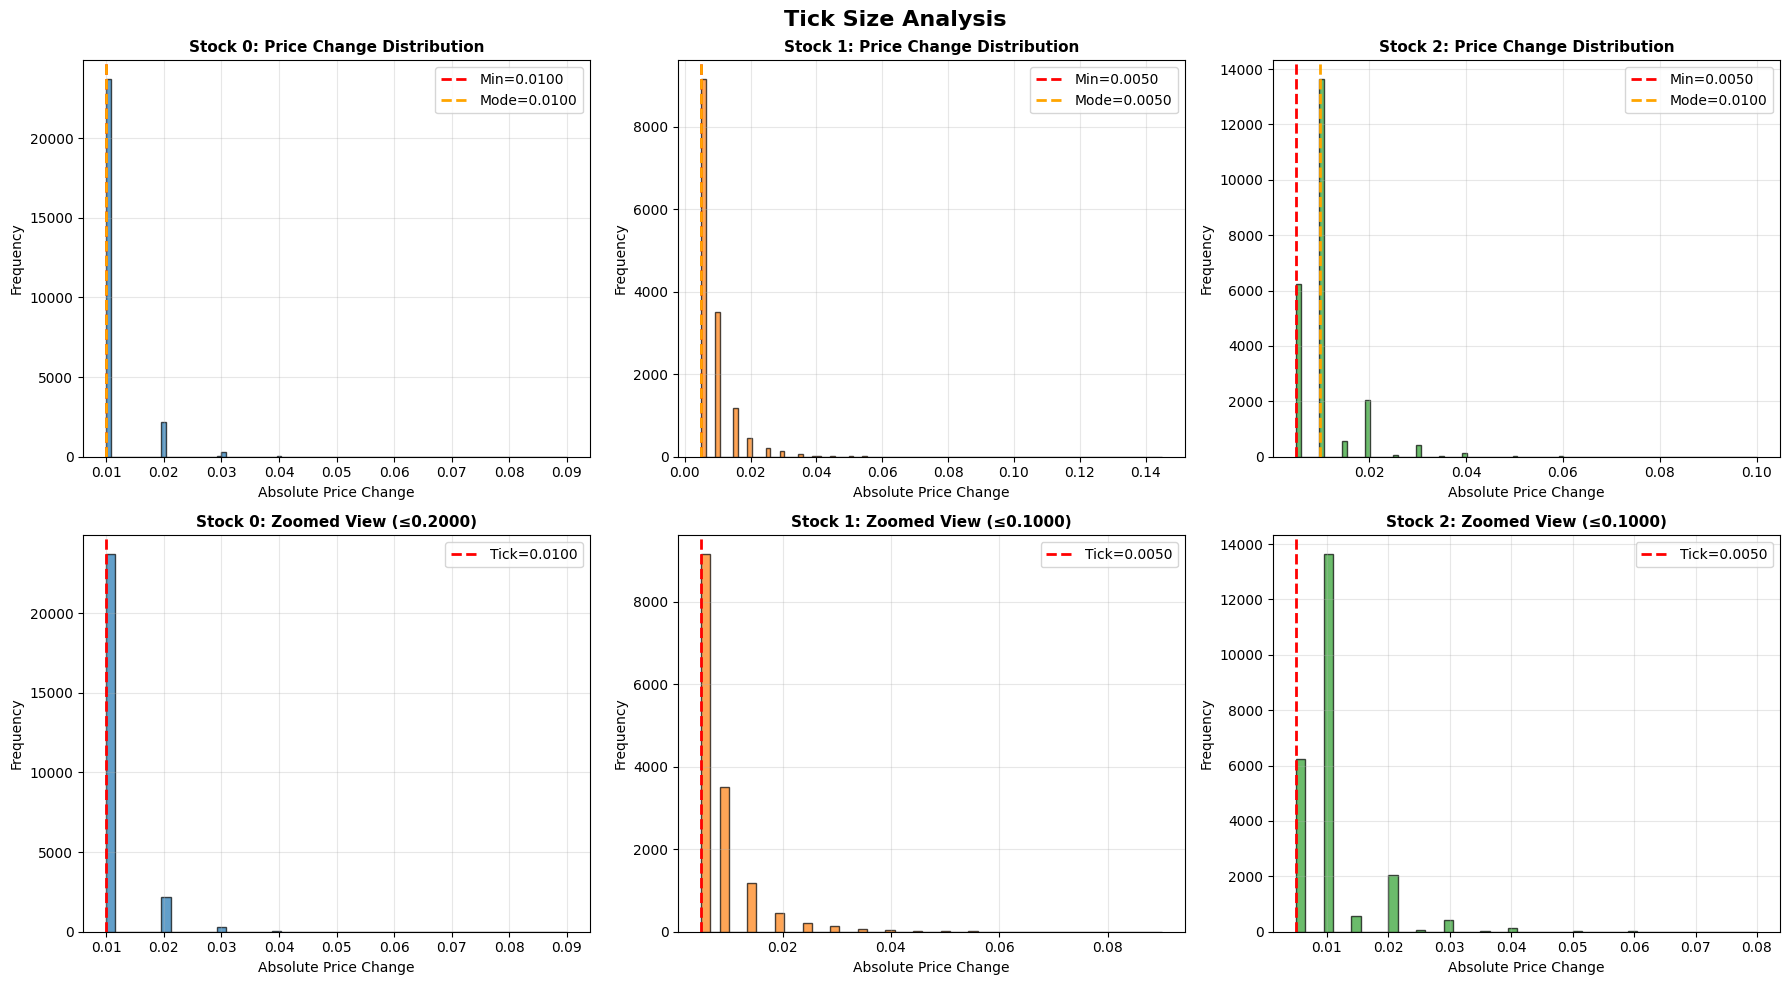

In [48]:
# Visualize tick size distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Tick Size Analysis', fontsize=16, fontweight='bold')

# Plot distribution of price changes for each stock
for idx, stock in enumerate(sorted(df['stock'].unique())):
    ax = axes[0, idx]
    stock_data = df_sorted[df_sorted['stock'] == stock]['price_change']
    non_zero_changes = stock_data[stock_data != 0].abs().dropna()
    
    # Histogram of absolute price changes
    ax.hist(non_zero_changes, bins=100, alpha=0.7, color=f'C{idx}', edgecolor='black')
    ax.set_xlabel('Absolute Price Change', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Stock {stock}: Price Change Distribution', fontsize=11, fontweight='bold')
    ax.axvline(tick_sizes[stock]['min'], color='red', linestyle='--', linewidth=2, 
               label=f'Min={tick_sizes[stock]["min"]:.4f}')
    ax.axvline(tick_sizes[stock]['mode'], color='orange', linestyle='--', linewidth=2,
               label=f'Mode={tick_sizes[stock]["mode"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Zoom in on small price changes (bottom row)
    ax2 = axes[1, idx]
    # Only show changes up to 10 times the minimum tick
    max_display = tick_sizes[stock]['min'] * 20
    zoomed_changes = non_zero_changes[non_zero_changes <= max_display]
    
    if len(zoomed_changes) > 0:
        ax2.hist(zoomed_changes, bins=50, alpha=0.7, color=f'C{idx}', edgecolor='black')
        ax2.set_xlabel('Absolute Price Change', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.set_title(f'Stock {stock}: Zoomed View (≤{max_display:.4f})', fontsize=11, fontweight='bold')
        ax2.axvline(tick_sizes[stock]['min'], color='red', linestyle='--', linewidth=2,
                   label=f'Tick={tick_sizes[stock]["min"]:.4f}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

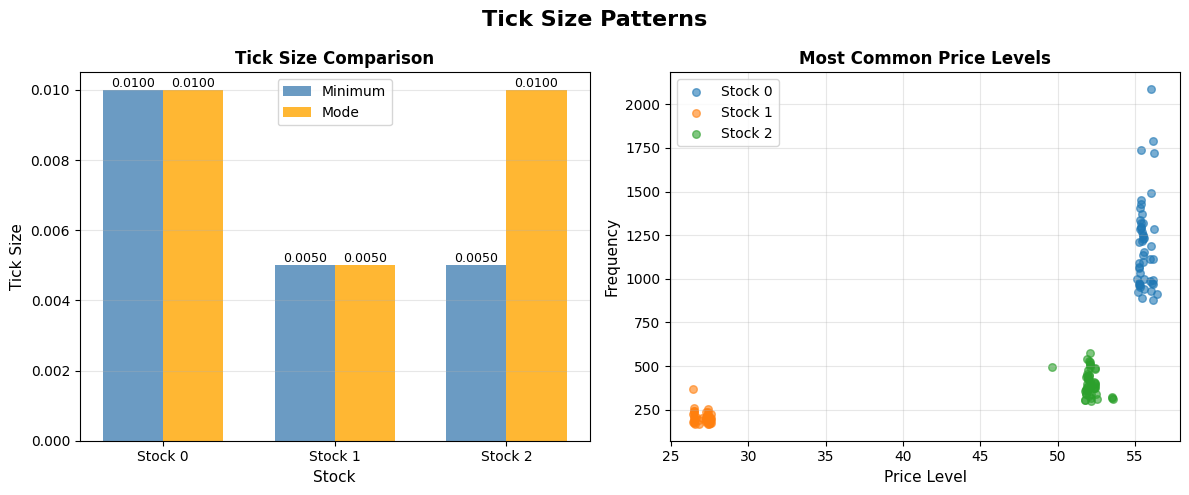

In [93]:
# Additional tick size visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Tick Size Patterns', fontsize=16, fontweight='bold')

# Bar chart comparing tick sizes across stocks
ax = axes[0]
stocks = sorted(df['stock'].unique())
min_ticks = [tick_sizes[s]['min'] for s in stocks]
mode_ticks = [tick_sizes[s]['mode'] for s in stocks]

x = np.arange(len(stocks))
width = 0.35
ax.bar(x - width/2, min_ticks, width, label='Minimum', alpha=0.8, color='steelblue')
ax.bar(x + width/2, mode_ticks, width, label='Mode', alpha=0.8, color='orange')

ax.set_xlabel('Stock', fontsize=11)
ax.set_ylabel('Tick Size', fontsize=11)
ax.set_title('Tick Size Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Stock {s}' for s in stocks])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (min_val, mode_val) in enumerate(zip(min_ticks, mode_ticks)):
    ax.text(i - width/2, min_val, f'{min_val:.4f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, mode_val, f'{mode_val:.4f}', ha='center', va='bottom', fontsize=9)

# Distribution of price levels (to check discreteness)
ax = axes[1]
for stock in sorted(df['stock'].unique()):
    stock_prices = df[df['stock'] == stock]['price']
    unique_prices = stock_prices.value_counts().head(50)
    ax.scatter(unique_prices.index, unique_prices.values, alpha=0.6, s=30, label=f'Stock {stock}')

ax.set_xlabel('Price Level', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Most Common Price Levels', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [94]:
for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].copy()
    
    unique_prices = np.sort(stock_data['price'].unique())
    price_diffs = np.diff(unique_prices)
    price_diffs = price_diffs[price_diffs > 0]
    
    min_diff = price_diffs.min() if len(price_diffs) > 0 else 0
    gcd_estimate = np.round(min_diff, 4)
    
    print(f"\nStock {stock}:")
    print(f"  Number of unique prices: {len(unique_prices)}")
    print(f"  Price range: [{unique_prices.min():.4f}, {unique_prices.max():.4f}]")
    print(f"  Minimum price difference: {min_diff:.4f}")
    print(f"  Estimated tick size: {gcd_estimate:.4f}")
    
    most_common_diffs = pd.Series(price_diffs).round(4).value_counts().head(5)
    print(f"  Most common price differences:")
    for diff, count in most_common_diffs.items():
        print(f"    {diff:.4f}: {count} occurrences")


Stock 0:
  Number of unique prices: 289
  Price range: [54.5300, 57.4100]
  Minimum price difference: 0.0100
  Estimated tick size: 0.0100
  Most common price differences:
    0.0100: 288 occurrences

Stock 1:
  Number of unique prices: 358
  Price range: [26.0300, 27.8150]
  Minimum price difference: 0.0050
  Estimated tick size: 0.0050
  Most common price differences:
    0.0050: 357 occurrences

Stock 2:
  Number of unique prices: 722
  Price range: [48.2500, 53.8500]
  Minimum price difference: 0.0050
  Estimated tick size: 0.0050
  Most common price differences:
    0.0100: 370 occurrences
    0.0050: 350 occurrences
    0.1500: 1 occurrences


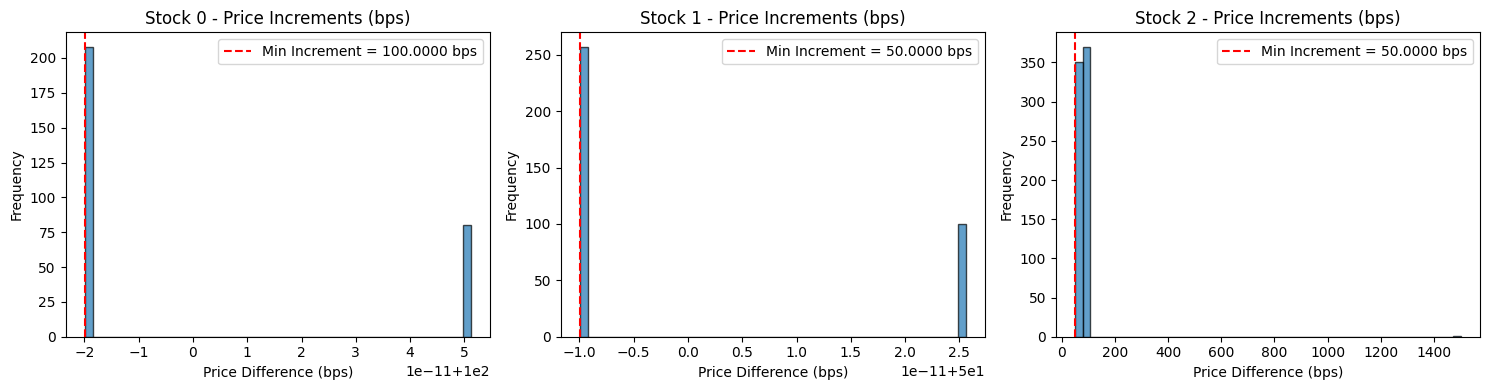

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, stock in enumerate(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    unique_prices = np.sort(stock_data['price'].unique())
    # Calculate price increments in basis points (bps): (diff / price) * 10000
    price_diffs_bps = (np.diff(unique_prices) ) * 10000
    price_diffs_bps = price_diffs_bps[price_diffs_bps > 0]
    
    axes[i].hist(price_diffs_bps, bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Stock {stock} - Price Increments (bps)')
    axes[i].set_xlabel('Price Difference (bps)')
    axes[i].set_ylabel('Frequency')
    min_bps = price_diffs_bps.min()
    axes[i].axvline(x=min_bps, color='red', linestyle='--', label=f'Min Increment = {min_bps:.4f} bps')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Comments on Tick Size Analysis:

The tick size represents the minimum price movement possible for each stock.

Key Findings:

- Different stocks may have different tick sizes depending on their price level and exchange rules.

- Price clustering around round numbers is typical in financial markets.

- The most common price differences reveal the effective tick size used by market participants.

- Tick sizes are important because they affect:
   - Spread: The minimum bid-ask spread is atleast one tick.
   - Market quality: Smaller ticks allow finer price discovery but may reduce market making profitability.
   - Trading costs: Larger ticks mean higher implicit transaction costs

---
### 1.3 Intraday activity: Intraday trading activity

We analyze how trading activity varies throughout the trading day. High-frequency trading typically shows characteristic patterns with high activity at market open and close.

In [102]:
# Prepare time-based features for intraday analysis
df['ts'] = pd.to_datetime(df['ts'])
df['dt'] = df.groupby(['stock', 'day'])['ts'].diff().dt.total_seconds()
df['turnover'] = df['price'] * df['qty']

# Time components
df['time'] = df['ts'].dt.time
df['hour'] = df['ts'].dt.hour
df['minute'] = df['ts'].dt.minute
df['time_decimal'] = df['hour'] + df['minute']/60

# Time bins
df['time_bin_5min'] = df['ts'].dt.floor('5min').dt.time
df['time_bin_30min'] = df['ts'].dt.floor('30min').dt.time
df['time_bin_15min'] = df['ts'].dt.floor('15min').dt.time
df['time_bin_1hour'] = df['ts'].dt.floor('1h').dt.time

df_sorted = df.sort_values(['stock', 'day', 'ts'])
df_sorted['price_change'] = df_sorted.groupby(['stock', 'day'])['price'].diff()


Intraday Trading Activity Summary by Stock:

Stock 0:
  Trading hours: 09:00:27 to 17:29:59
  Total trades: 143,963
  Avg trades per hour: 15995.9
  Most active hour: 16h (25,289 trades)

Stock 1:
  Trading hours: 09:00:48 to 17:29:54
  Total trades: 37,522
  Avg trades per hour: 4169.1
  Most active hour: 16h (6,104 trades)

Stock 2:
  Trading hours: 09:00:26 to 17:30:00
  Total trades: 78,209
  Avg trades per hour: 8689.9
  Most active hour: 15h (12,218 trades)


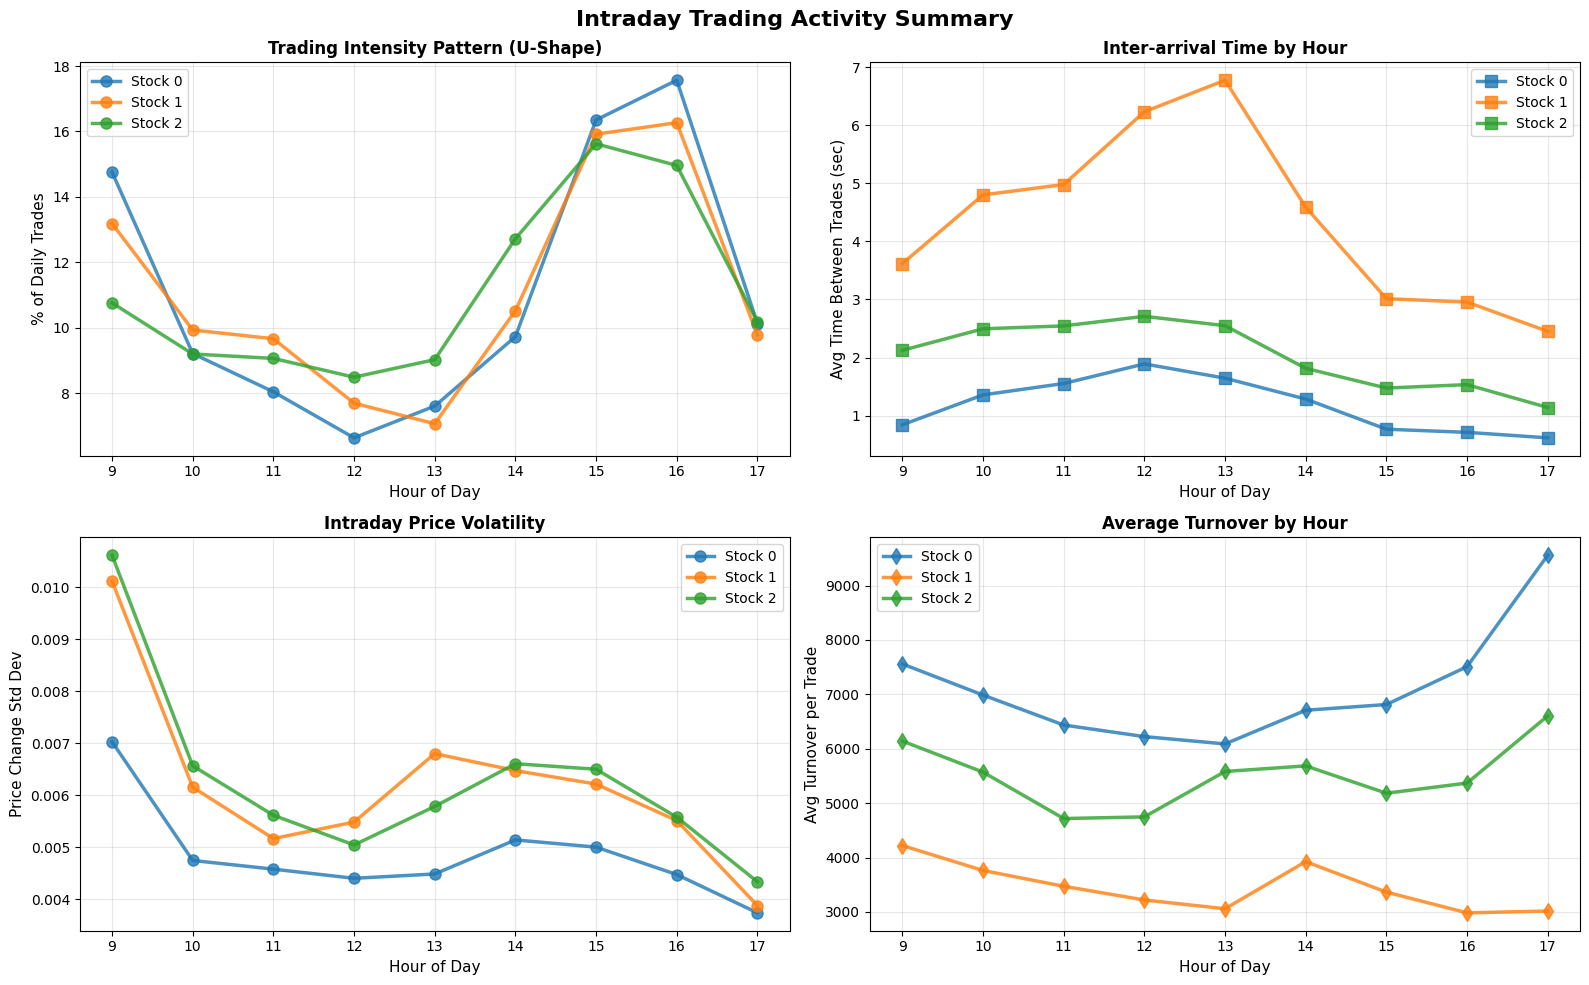

In [ ]:
# Calculate various intraday metrics and create summary visualizations
print("\nIntraday Trading Activity Summary by Stock:")
print("=" * 80)

# Aggregate key metrics
for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    print(f"\nStock {stock}:")
    print(f"  Trading hours: {stock_data['ts'].min().strftime('%H:%M:%S')} to {stock_data['ts'].max().strftime('%H:%M:%S')}")
    print(f"  Total trades: {len(stock_data):,}")
    print(f"  Avg trades per hour: {len(stock_data) / stock_data['hour'].nunique():.1f}")
    print(f"  Most active hour: {stock_data['hour'].value_counts().idxmax()}h ({stock_data['hour'].value_counts().max():,} trades)")

# Create two comprehensive summary figures
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Intraday Trading Activity Summary', fontsize=16, fontweight='bold')

# Trading intensity throughout the day (normalized)
ax = axes[0, 0]
for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    hourly_trades = stock_data.groupby('hour').size()
    normalized = (hourly_trades / hourly_trades.sum() * 100)
    ax.plot(normalized.index, normalized.values, marker='o', linewidth=2.5, 
             markersize=8, label=f'Stock {stock}', alpha=0.8)

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('% of Daily Trades', fontsize=11)
ax.set_title('Trading Intensity Pattern (U-Shape)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Average inter-arrival time by hour
ax = axes[0, 1]
for stock in sorted(df['stock'].unique()):
    stock_dt = df[df['stock'] == stock].groupby('hour')['dt'].mean()
    ax.plot(stock_dt.index, stock_dt.values, marker='s', linewidth=2.5, 
             markersize=8, label=f'Stock {stock}', alpha=0.8)

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Avg Time Between Trades (sec)', fontsize=11)
ax.set_title('Inter-arrival Time by Hour', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Price volatility by hour
ax = axes[1, 0]
for stock in sorted(df['stock'].unique()):
    stock_vol = df_sorted[df_sorted['stock'] == stock].groupby('hour')['price_change'].std()
    ax.plot(stock_vol.index, stock_vol.values, marker='o', linewidth=2.5, 
             markersize=8, label=f'Stock {stock}', alpha=0.8)

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Price Change Std Dev', fontsize=11)
ax.set_title('Intraday Price Volatility', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Average turnover by hour
ax = axes[1, 1]
for stock in sorted(df['stock'].unique()):
    stock_turnover = df[df['stock'] == stock].groupby('hour')['turnover'].mean()
    ax.plot(stock_turnover.index, stock_turnover.values, marker='d', linewidth=2.5,
            markersize=8, label=f'Stock {stock}', alpha=0.8)

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Avg Turnover per Trade', fontsize=11)
ax.set_title('Average Turnover by Hour', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

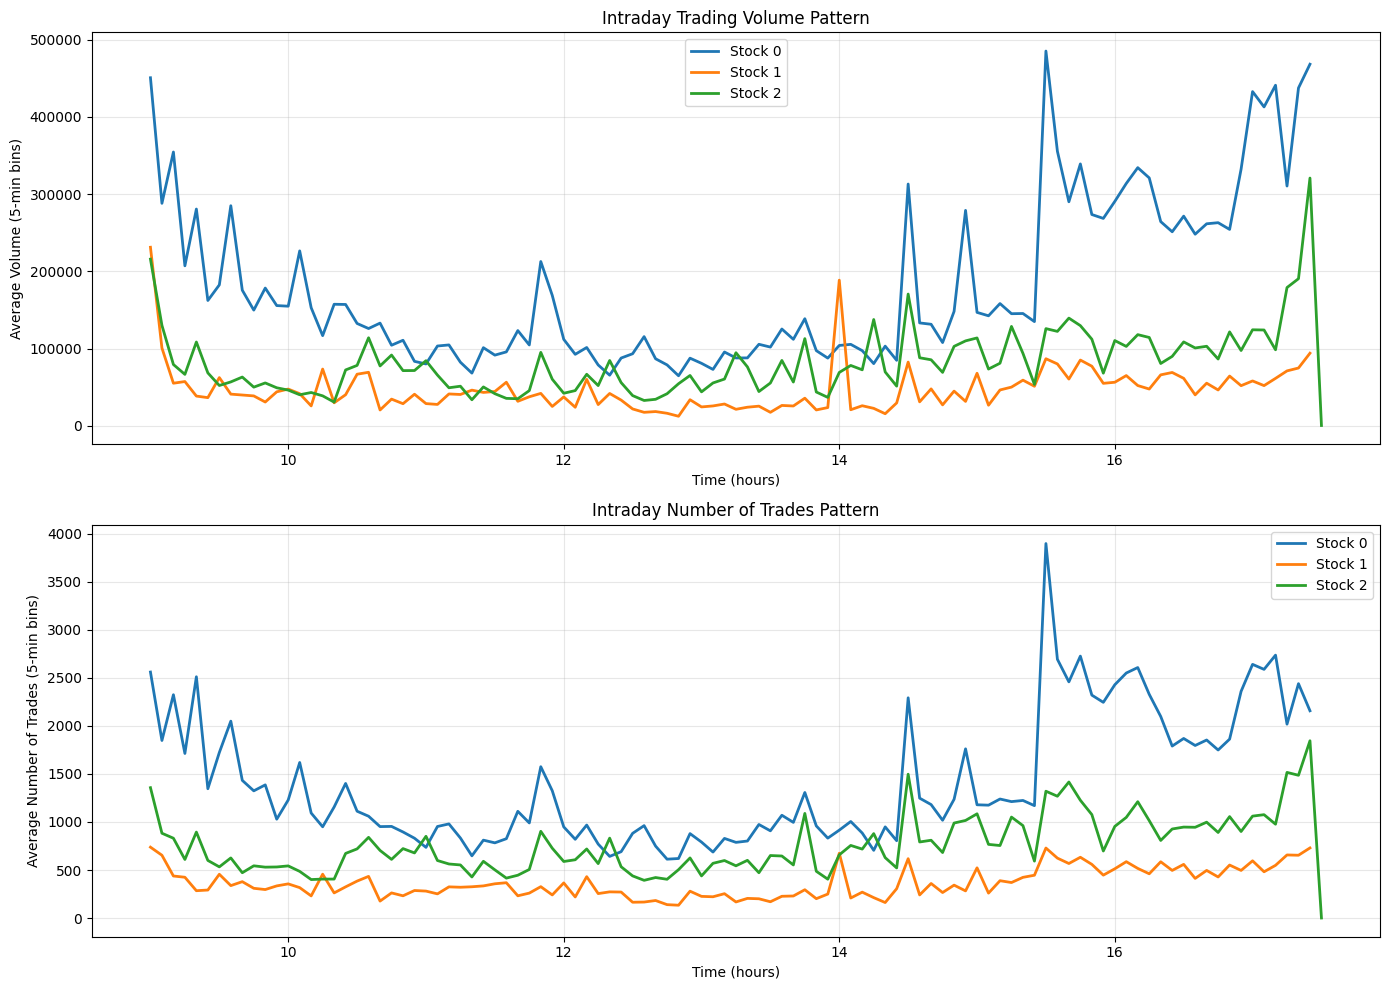

In [105]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

intraday_activity = df.groupby(['stock', 'time_bin_5min']).agg({
    'qty': ['sum', 'count'],
    'price': 'mean'
}).reset_index()

intraday_activity.columns = ['stock', 'time_bin_5min', 'total_volume', 'num_trades', 'avg_price']
# Convert time to decimal hours
intraday_activity['time_hours'] = intraday_activity['time_bin_5min'].apply(
    lambda t: t.hour + t.minute / 60 + t.second / 3600
)

for stock in df['stock'].unique():
    stock_data = intraday_activity[intraday_activity['stock'] == stock]
    avg_by_time = stock_data.groupby('time_hours')[['total_volume', 'num_trades']].mean()
    axes[0].plot(avg_by_time.index, avg_by_time['total_volume'], label=f'Stock {stock}', linewidth=2)
    axes[1].plot(avg_by_time.index, avg_by_time['num_trades'], label=f'Stock {stock}', linewidth=2)

axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Average Volume (5-min bins)')
axes[0].set_title('Intraday Trading Volume Pattern')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('Average Number of Trades (5-min bins)')
axes[1].set_title('Intraday Number of Trades Pattern')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

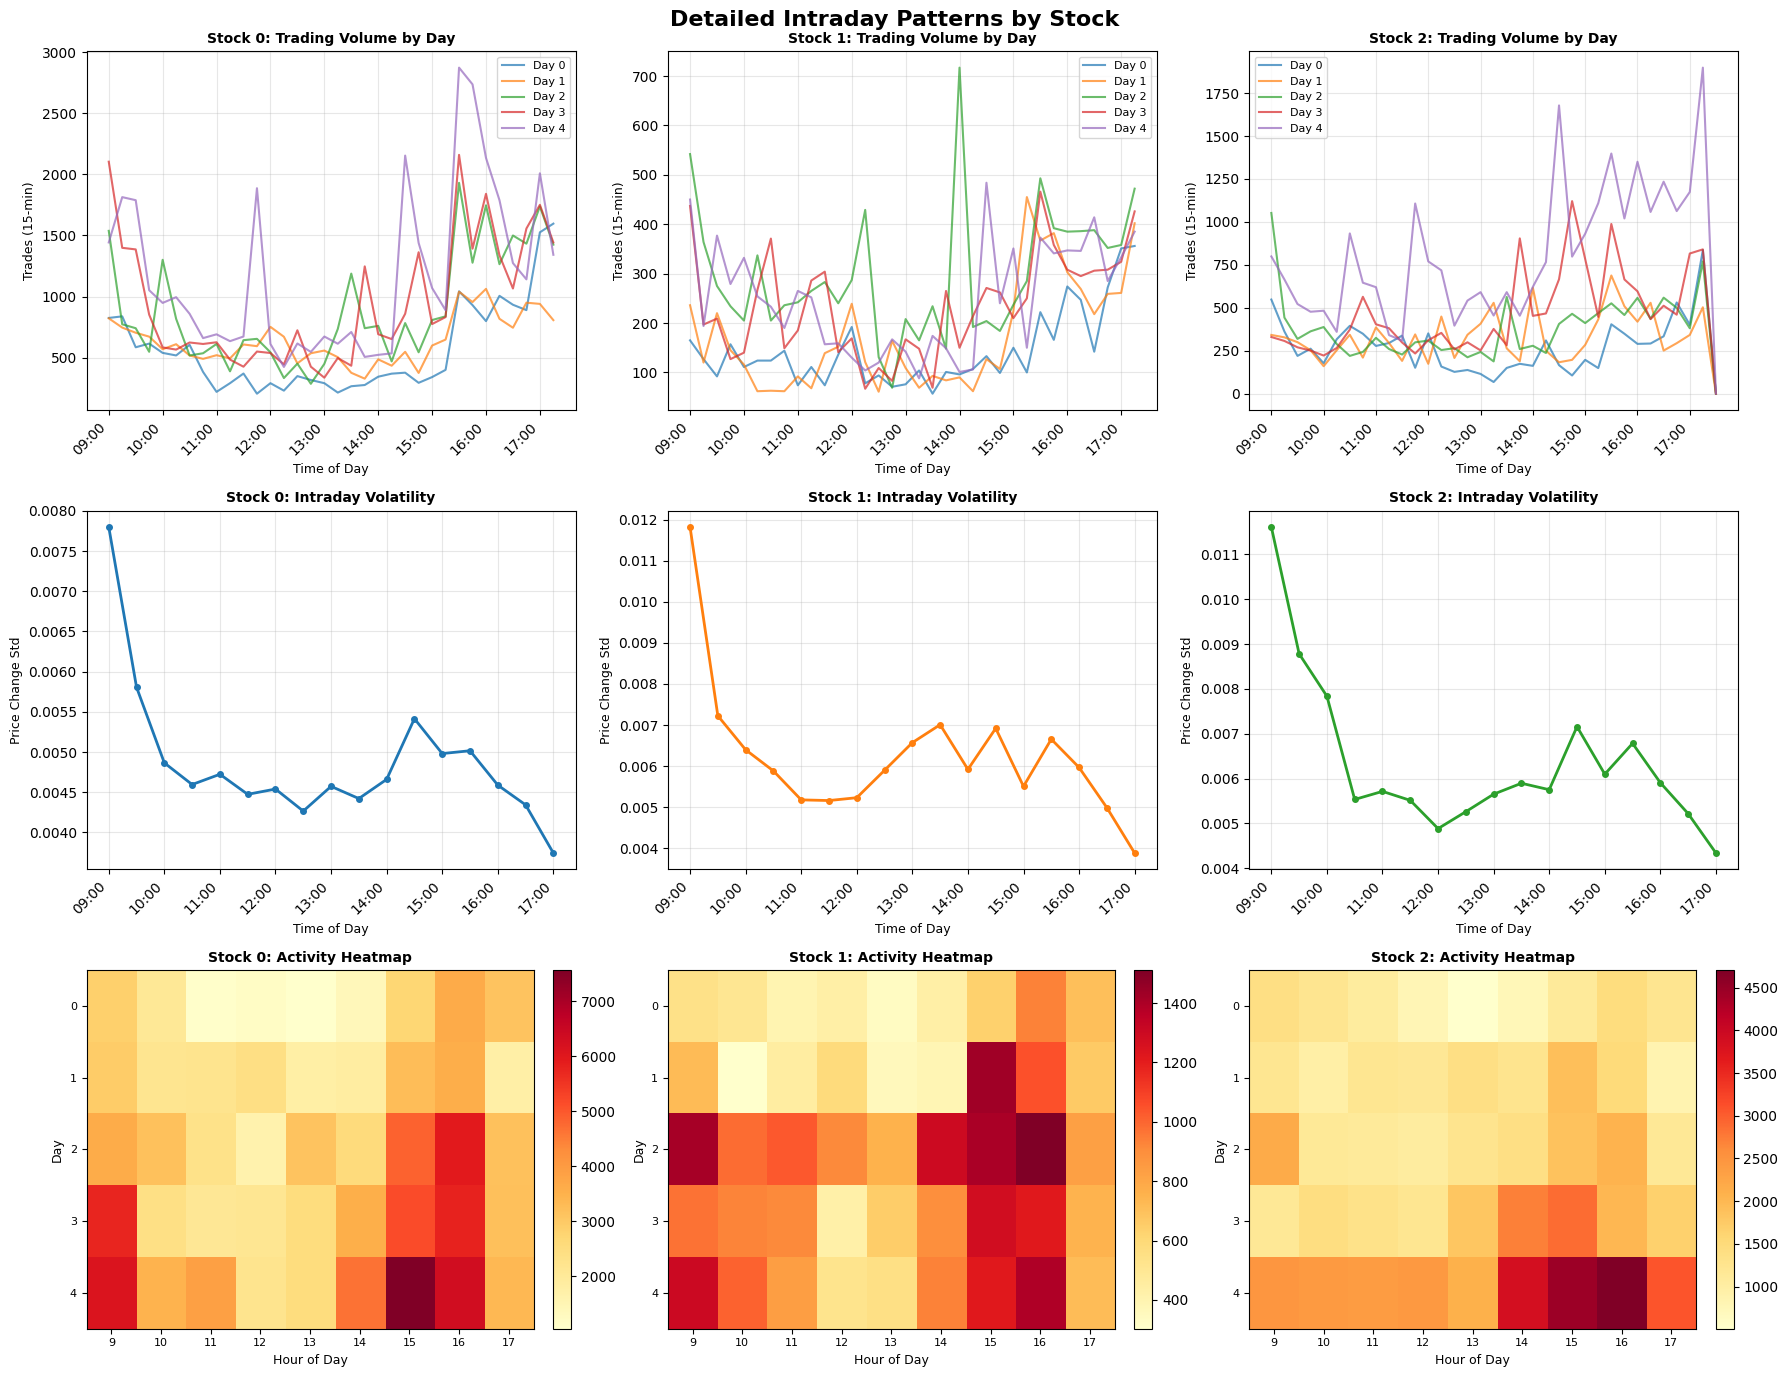

In [ ]:
# Detailed analysis by stock
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Detailed Intraday Patterns by Stock', fontsize=16, fontweight='bold')

for idx, stock in enumerate(sorted(df['stock'].unique())):
    stock_data = df[df['stock'] == stock]
    
    # Trading volume by 15-min intervals for each day
    ax = axes[0, idx]
    trades_15min = stock_data.groupby(['day', 'time_bin_15min']).size().unstack(fill_value=0)
    
    for day in trades_15min.index:
        times = [pd.Timestamp.combine(pd.Timestamp.today(), t) for t in trades_15min.columns]
        ax.plot(times, trades_15min.loc[day], linewidth=1.5, 
                label=f'Day {day}', alpha=0.7)
    
    ax.set_xlabel('Time of Day', fontsize=9)
    ax.set_ylabel('Trades (15-min)', fontsize=9)
    ax.set_title(f'Stock {stock}: Trading Volume by Day', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Price volatility throughout the day
    ax = axes[1, idx]
    stock_sorted = df_sorted[df_sorted['stock'] == stock]
    
    # Volatility by 30-min bins
    stock_sorted['time_bin_30min'] = stock_sorted['ts'].dt.floor('30min').dt.time
    vol_30min = stock_sorted.groupby('time_bin_30min')['price_change'].std()
    
    times = [pd.Timestamp.combine(pd.Timestamp.today(), t) for t in vol_30min.index]
    ax.plot(times, vol_30min.values, marker='o', linewidth=2, 
            markersize=4, color=f'C{idx}')
    
    ax.set_xlabel('Time of Day', fontsize=9)
    ax.set_ylabel('Price Change Std', fontsize=9)
    ax.set_title(f'Stock {stock}: Intraday Volatility', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Heatmap of trading intensity by hour and day
    ax = axes[2, idx]
    heatmap_data = stock_data.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    im = ax.imshow(heatmap_data.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax.set_xlabel('Hour of Day', fontsize=9)
    ax.set_ylabel('Day', fontsize=9)
    ax.set_title(f'Stock {stock}: Activity Heatmap', fontsize=10, fontweight='bold')
    ax.set_xticks(range(len(heatmap_data.columns)))
    ax.set_yticks(range(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns, fontsize=8)
    ax.set_yticklabels(heatmap_data.index, fontsize=8)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
# Statistical tests and metrics for intraday patterns
from IPython.display import display

# U-shaped pattern analysis
print("U-Shape Pattern Analysis")
u_shape_data = []
for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    hourly = stock_data.groupby('hour').size()
    
    if len(hourly) > 0:
        first_hour_trades = hourly.iloc[0]
        last_hour_trades = hourly.iloc[-1]
        middle_hour_trades = hourly.iloc[len(hourly)//2]
        mean_trades = hourly.mean()
        
        u_shape_data.append({
            'Stock': stock,
            'First Hour Trades': first_hour_trades,
            'First/Avg Ratio': f"{first_hour_trades/mean_trades:.2f}x",
            'Middle Hour Trades': middle_hour_trades,
            'Middle/Avg Ratio': f"{middle_hour_trades/mean_trades:.2f}x",
            'Last Hour Trades': last_hour_trades,
            'Last/Avg Ratio': f"{last_hour_trades/mean_trades:.2f}x",
            'U-Shape Ratio': f"{(first_hour_trades + last_hour_trades)/(2*middle_hour_trades):.2f}"
        })

u_shape_df = pd.DataFrame(u_shape_data)
display(u_shape_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
]))

# Peak trading hours
print("Peak Trading Hours")
peak_data = []
for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    hourly = stock_data.groupby('hour').size().sort_values(ascending=False)
    
    peak_data.append({
        'Stock': stock,
        'Peak Hour': f"{hourly.index[0]}:00",
        'Peak Trades': hourly.iloc[0],
        'Top 3 Hours': f"{hourly.index[0]}, {hourly.index[1]}, {hourly.index[2]}",
        'Quietest Hour': f"{hourly.index[-1]}:00",
        'Quietest Trades': hourly.iloc[-1]
    })

peak_df = pd.DataFrame(peak_data)
display(peak_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
]))

# Variance and concentration analysis
print("Trading Intensity Statistics")
intensity_data = []
for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock]
    hourly = stock_data.groupby('hour').size()
    hourly_sorted = hourly.sort_values(ascending=False)
    total = hourly.sum()
    
    cv = hourly.std() / hourly.mean()
    top3_pct = hourly_sorted.iloc[:3].sum() / total * 100
    top5_pct = hourly_sorted.iloc[:5].sum() / total * 100
    
    intensity_data.append({
        'Stock': stock,
        'Mean Trades/Hour': f"{hourly.mean():.2f}",
        'Std Dev': f"{hourly.std():.2f}",
        'Coeff of Variation': f"{cv:.2f}",
        'Range': f"{hourly.min()} - {hourly.max()}",
        'Top 3 Hours %': f"{top3_pct:.1f}%",
        'Top 5 Hours %': f"{top5_pct:.1f}%"
    })

intensity_df = pd.DataFrame(intensity_data)
display(intensity_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
]))

U-Shape Pattern Analysis


Peak Trading Hours


Trading Intensity Statistics


The intraday trading activity shows the classic U-shaped pattern (also called the "smile" pattern):

We observe:
- High activity at market open (9:00-10:00): Traders react to overnight news and adjust positions.
- Lower activity during midday: Reduced trading intensity as market participants wait for new information.
- High activity at market close (16:00-17:30): Portfolio rebalancing, end-of-day executions, and closing auctions.

This pattern is well-documented in market microstructure literature and reflects:
- Information arrival patterns
- Institutional trading behavior
- Market maker inventory management
- Index rebalancing effects

---
### 1.4 Volatility and traded volume: Link between volatility and traded volume?

We investigate the relationship between volatility and traded volume. This is important for understanding market dynamics and the impact of trading on price movements.

In [113]:
vol_volume_data = []

for stock in df['stock'].unique():
    stock_data = df[df['stock'] == stock].copy()
    
    for day in stock_data['day'].unique():
        day_data = stock_data[stock_data['day'] == day].copy()
        
        for time_bin in day_data['time_bin_5min'].unique():
            bin_data = day_data[day_data['time_bin_5min'] == time_bin]
            
            if len(bin_data) > 1:
                log_returns = np.diff(np.log(bin_data['price'].values))
                realized_vol = np.std(log_returns) * np.sqrt(len(log_returns)) if len(log_returns) > 0 else 0
                total_volume = bin_data['qty'].sum()
                num_trades = len(bin_data)
                
                vol_volume_data.append({
                    'stock': stock,
                    'day': day,
                    'time_bin': time_bin,
                    'realized_vol': realized_vol,
                    'volume': total_volume,
                    'num_trades': num_trades
                })

vol_volume_df = pd.DataFrame(vol_volume_data)

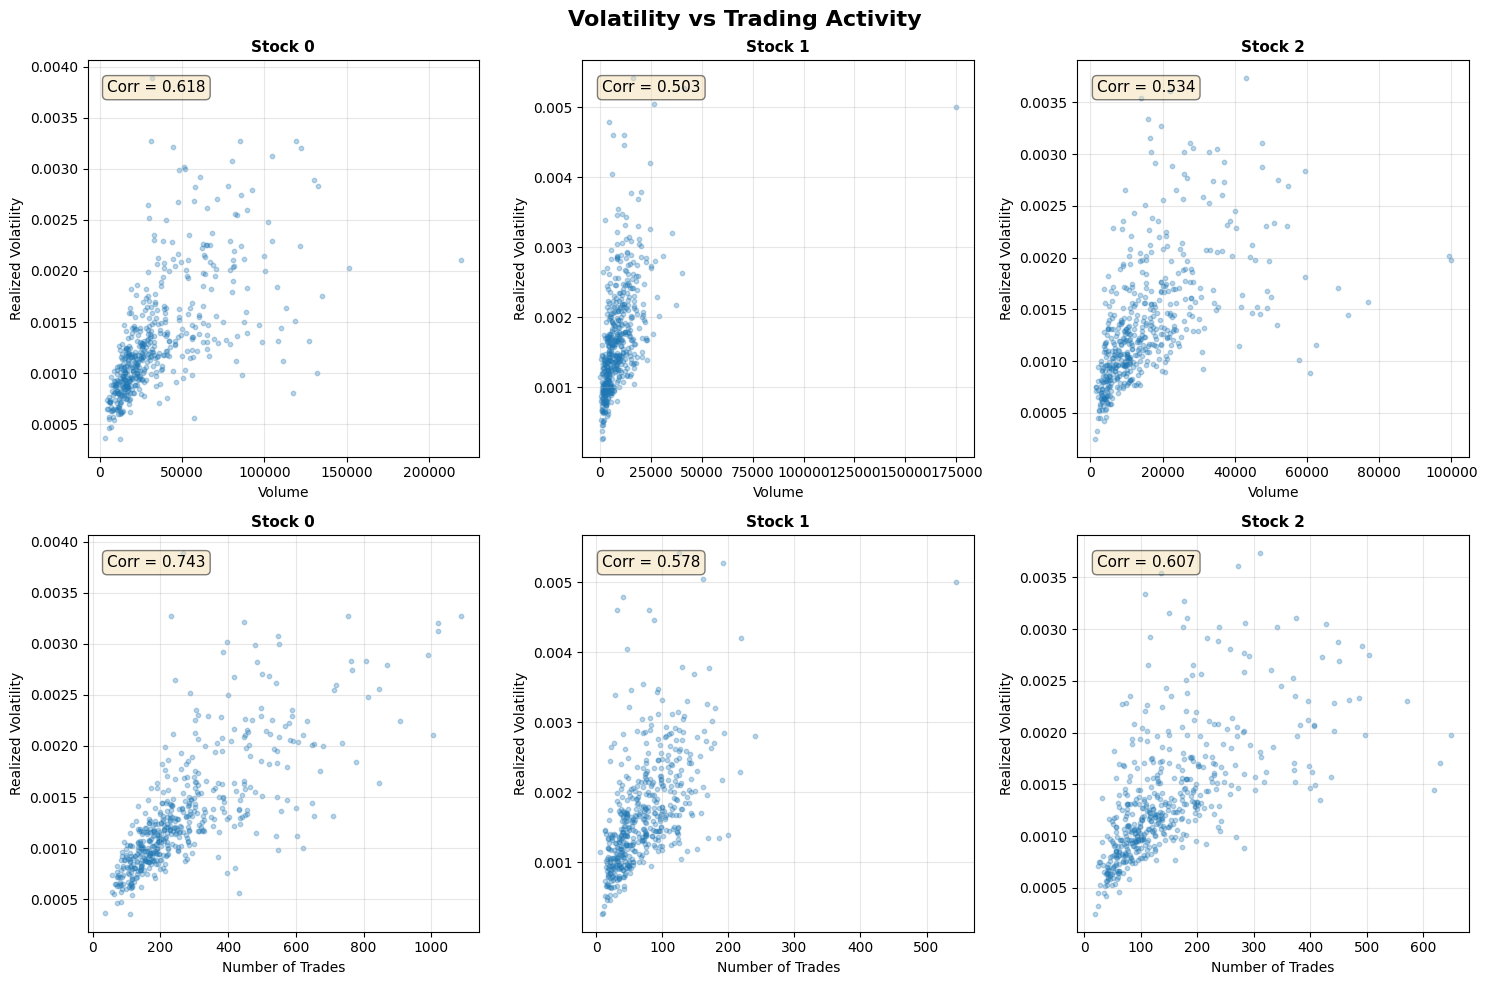

In [114]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Volatility vs Trading Activity', fontsize=16, fontweight='bold')

for i, stock in enumerate(sorted(vol_volume_df['stock'].unique())):
    stock_data = vol_volume_df[vol_volume_df['stock'] == stock]
    stock_data = stock_data[(stock_data['realized_vol'] > 0) & (stock_data['realized_vol'] < stock_data['realized_vol'].quantile(0.99))]
    
    ax = axes[0, i]
    ax.scatter(stock_data['volume'], stock_data['realized_vol'], alpha=0.3, s=10)
    ax.set_xlabel('Volume', fontsize=10)
    ax.set_ylabel('Realized Volatility', fontsize=10)
    ax.set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    
    correlation = stock_data['volume'].corr(stock_data['realized_vol'])
    ax.text(0.05, 0.95, f'Corr = {correlation:.3f}', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, i]
    ax.scatter(stock_data['num_trades'], stock_data['realized_vol'], alpha=0.3, s=10)
    ax.set_xlabel('Number of Trades', fontsize=10)
    ax.set_ylabel('Realized Volatility', fontsize=10)
    ax.set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    
    correlation2 = stock_data['num_trades'].corr(stock_data['realized_vol'])
    ax.text(0.05, 0.95, f'Corr = {correlation2:.3f}', transform=ax.transAxes,
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [116]:
print("Volatility-Volume Correlation Analysis\n")

for stock in sorted(vol_volume_df['stock'].unique()):
    stock_data = vol_volume_df[vol_volume_df['stock'] == stock]
    stock_data = stock_data[(stock_data['realized_vol'] > 0) & (stock_data['realized_vol'] < stock_data['realized_vol'].quantile(0.99))]
    
    corr_vol_volume = stock_data['volume'].corr(stock_data['realized_vol'])
    corr_vol_trades = stock_data['num_trades'].corr(stock_data['realized_vol'])
    
    spearman_vol = stats.spearmanr(stock_data['volume'], stock_data['realized_vol'])[0]
    spearman_trades = stats.spearmanr(stock_data['num_trades'], stock_data['realized_vol'])[0]
    
    print(f"\nStock {stock}:")
    print(f"Pearson correlation (Vol vs Volume): {corr_vol_volume:.4f}")
    print(f"Pearson correlation (Vol vs Num Trades): {corr_vol_trades:.4f}")
    print(f"Spearman correlation (Vol vs Volume): {spearman_vol:.4f}")
    print(f"Spearman correlation (Vol vs Num Trades): {spearman_trades:.4f}")

Volatility-Volume Correlation Analysis


Stock 0:
Pearson correlation (Vol vs Volume): 0.6176
Pearson correlation (Vol vs Num Trades): 0.7426
Spearman correlation (Vol vs Volume): 0.7601
Spearman correlation (Vol vs Num Trades): 0.8054

Stock 1:
Pearson correlation (Vol vs Volume): 0.5031
Pearson correlation (Vol vs Num Trades): 0.5782
Spearman correlation (Vol vs Volume): 0.6530
Spearman correlation (Vol vs Num Trades): 0.6517

Stock 2:
Pearson correlation (Vol vs Volume): 0.5336
Pearson correlation (Vol vs Num Trades): 0.6066
Spearman correlation (Vol vs Volume): 0.6947
Spearman correlation (Vol vs Num Trades): 0.7151


### Volatility-Volume Relationship Analysis

The analysis reveals a positive correlation between volatility and trading volume, which is consistent with established market microstructure theory:

1. Information-based explanation: High volatility periods coincide with information arrival, which also drives trading activity.

2. Mixture of Distributions Hypothesis (MDH): Both volume and volatility are driven by a common latent information flow variable.

3. Sequential Information Arrival: New information causes both price movements (volatility) and trading (volume).

4. Positive correlation is expected and widely documented in the academic literature (e.g., Karpoff 1987 "The Relation Between Price Changes and Trading Volume: A Survey").

The correlation is typically stronger for number of trades than for total volume, suggesting that the frequency of transactions is more informative about price discovery than the size of individual trades.

---
### 1.5 High-frequency log returns: Distributions for various sampling frequencies in calendar time and event time

We compute and analyze the distribution of log-returns at various sampling frequencies. We distinguish between:
- Calendar time: Each observation is weighted by the time interval length
- Event time: Each trade counts as one observation

### Event Time Returns (Trade-by-Trade)

In event time, we compute returns between consecutive trades.

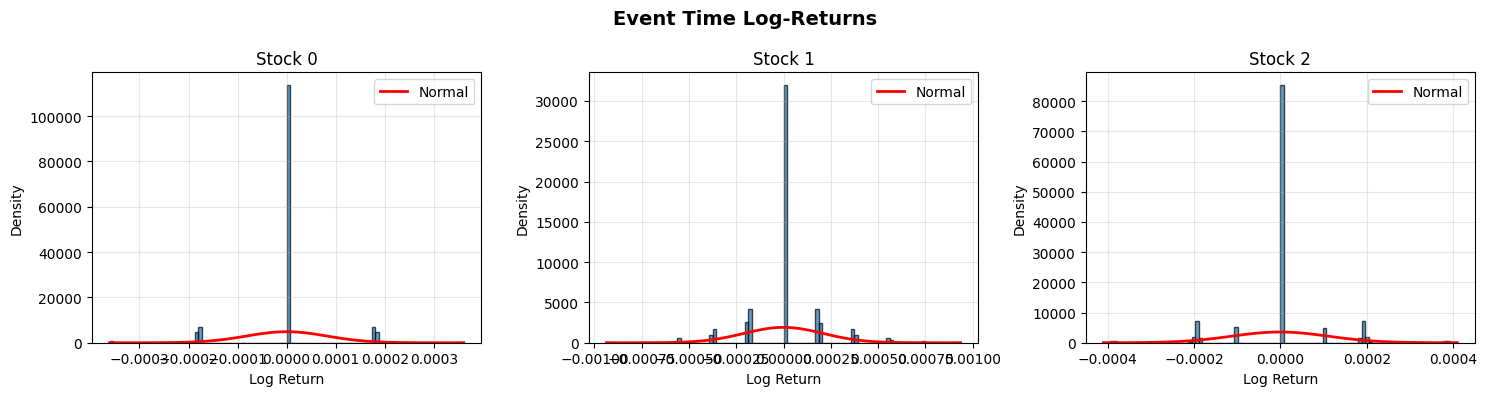

In [117]:
# Event time returns (trade-by-trade)
event_time_returns = {}

for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock].copy().sort_values('ts')
    stock_data['log_return'] = np.log(stock_data['price']).diff()
    stock_data = stock_data.dropna()
    event_time_returns[stock] = stock_data['log_return'].values

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Event Time Log-Returns', fontsize=14, fontweight='bold')

for i, stock in enumerate(event_time_returns.keys()):
    returns = event_time_returns[stock]
    returns_clean = returns[np.abs(returns) < np.percentile(np.abs(returns), 99)]
    
    axes[i].hist(returns_clean, bins=100, density=True, alpha=0.7, edgecolor='black')
    
    x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
    axes[i].plot(x, stats.norm.pdf(x, returns_clean.mean(), returns_clean.std()), 
                 'r-', linewidth=2, label='Normal')
    
    axes[i].set_title(f'Stock {stock}')
    axes[i].set_xlabel('Log Return')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Calendar Time Returns

In calendar time, we sample at regular time intervals (1s, 10s, 1min, 5min).

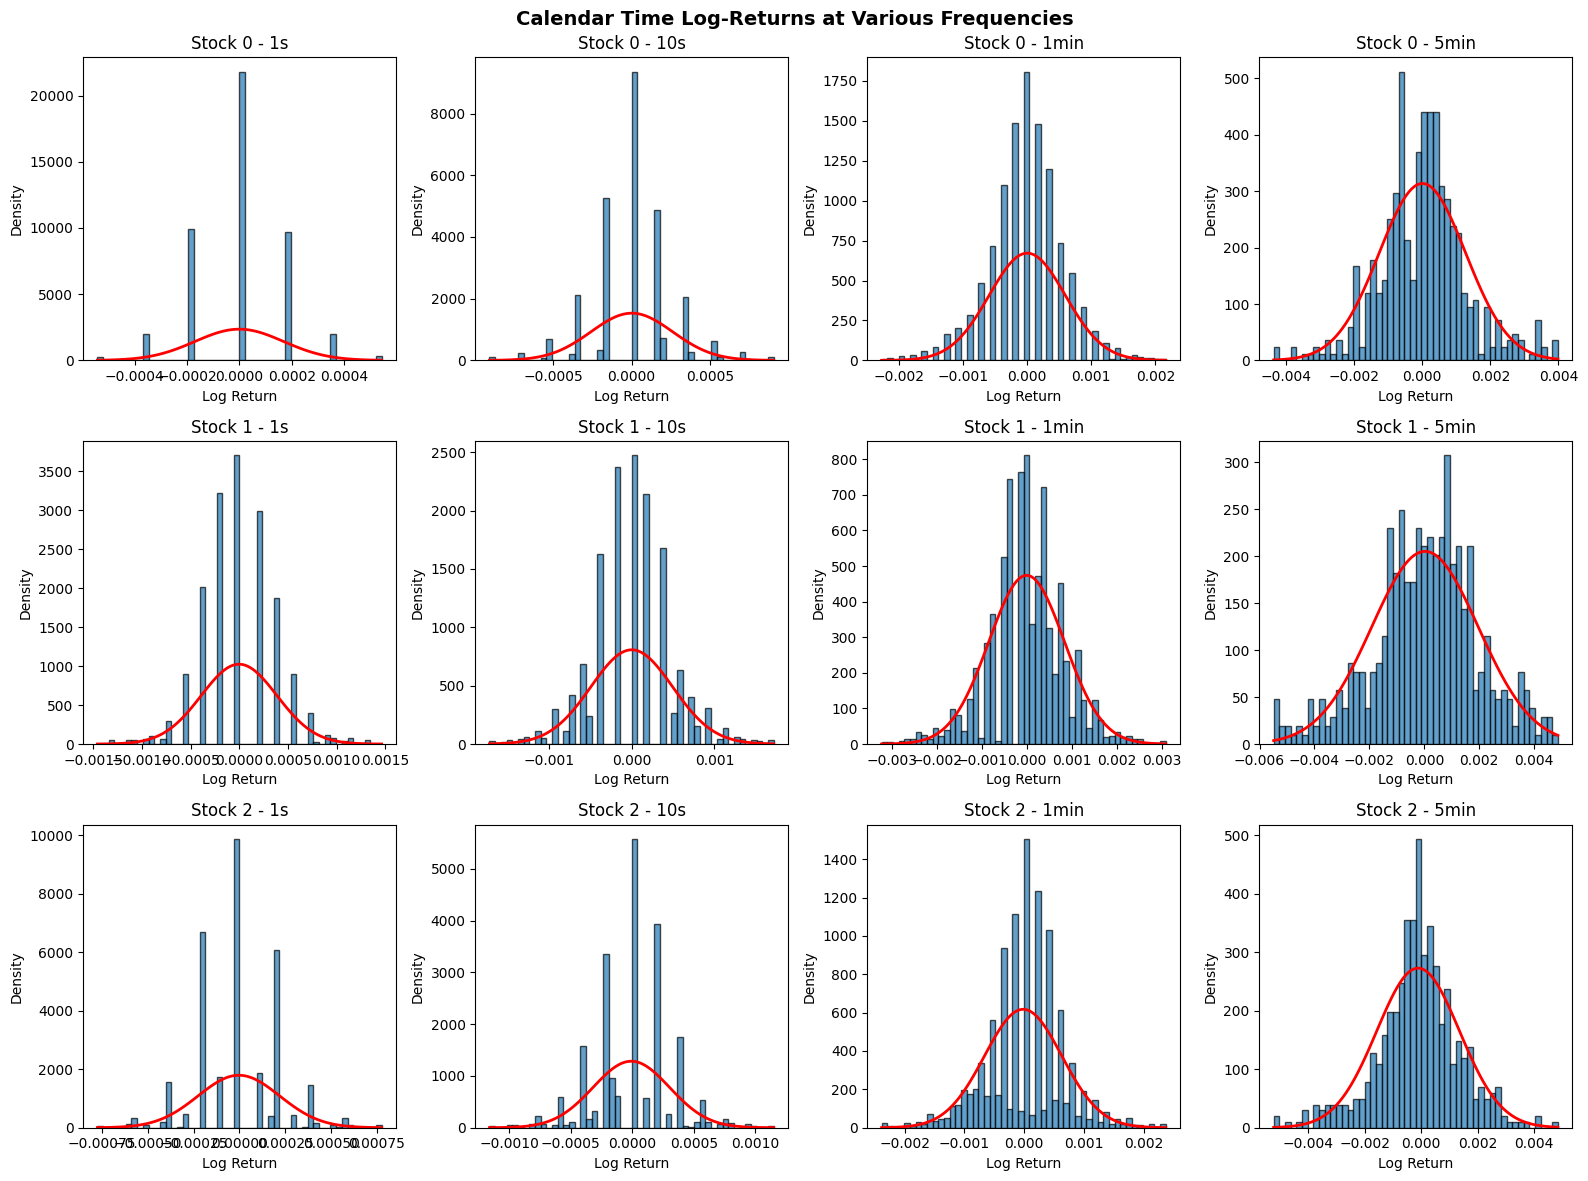

In [119]:
# Calendar time returns at various frequencies
sampling_frequencies = {
    '1s': '1s',
    '10s': '10s',
    '1min': '1min',
    '5min': '5min'
}

calendar_returns = {stock: {} for stock in sorted(df['stock'].unique())}

for stock in sorted(df['stock'].unique()):
    stock_data = df[df['stock'] == stock].copy()
    stock_data = stock_data.set_index('ts').sort_index()
    
    for freq_name, freq in sampling_frequencies.items():
        resampled = stock_data['price'].resample(freq).last().dropna()
        log_returns = np.log(resampled).diff().dropna()
        calendar_returns[stock][freq_name] = log_returns.values

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Calendar Time Log-Returns at Various Frequencies', fontsize=14, fontweight='bold')

for i, stock in enumerate(calendar_returns.keys()):
    for j, (freq_name, returns) in enumerate(calendar_returns[stock].items()):
        if len(returns) > 0:
            returns_clean = returns[np.abs(returns) < np.percentile(np.abs(returns), 99)]
            
            axes[i, j].hist(returns_clean, bins=50, density=True, alpha=0.7, edgecolor='black')
            
            x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
            axes[i, j].plot(x, stats.norm.pdf(x, returns_clean.mean(), returns_clean.std()), 
                           'r-', linewidth=2, label='Normal')
            
            axes[i, j].set_title(f'Stock {stock} - {freq_name}')
            axes[i, j].set_xlabel('Log Return')
            axes[i, j].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [123]:
from IPython.display import display, Markdown

print("Log-Returns Statistics")

all_stats = []

for stock in calendar_returns.keys():
    # Event Time statistics
    returns = event_time_returns[stock]
    all_stats.append({
        'Stock': stock,
        'Time Type': 'Event Time',
        'Frequency': 'trade-by-trade',
        'Mean': f"{np.mean(returns):.6f}",
        'Std': f"{np.std(returns):.6f}",
        'Skewness': f"{stats.skew(returns):.4f}",
        'Kurtosis': f"{stats.kurtosis(returns):.4f}",
        'N Obs': f"{len(returns):,}"
    })
    
    # Calendar Time statistics
    for freq_name, returns in calendar_returns[stock].items():
        if len(returns) > 0:
            all_stats.append({
                'Stock': stock,
                'Time Type': 'Calendar Time',
                'Frequency': freq_name,
                'Mean': f"{np.mean(returns):.6f}",
                'Std': f"{np.std(returns):.6f}",
                'Skewness': f"{stats.skew(returns):.4f}",
                'Kurtosis': f"{stats.kurtosis(returns):.4f}",
                'N Obs': f"{len(returns):,}"
            })

stats_df = pd.DataFrame(all_stats)

for stock in sorted(calendar_returns.keys()):
    print(f"Stock {stock}")
    stock_stats = stats_df[stats_df['Stock'] == stock].drop('Stock', axis=1)
    display(stock_stats.style.set_properties(**{'text-align': 'center'}).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#f0f0f0')]},
        {'selector': 'td', 'props': [('padding', '8px')]}
    ]).hide(axis='index'))


Log-Returns Statistics
Stock 0


Stock 1


Stock 2


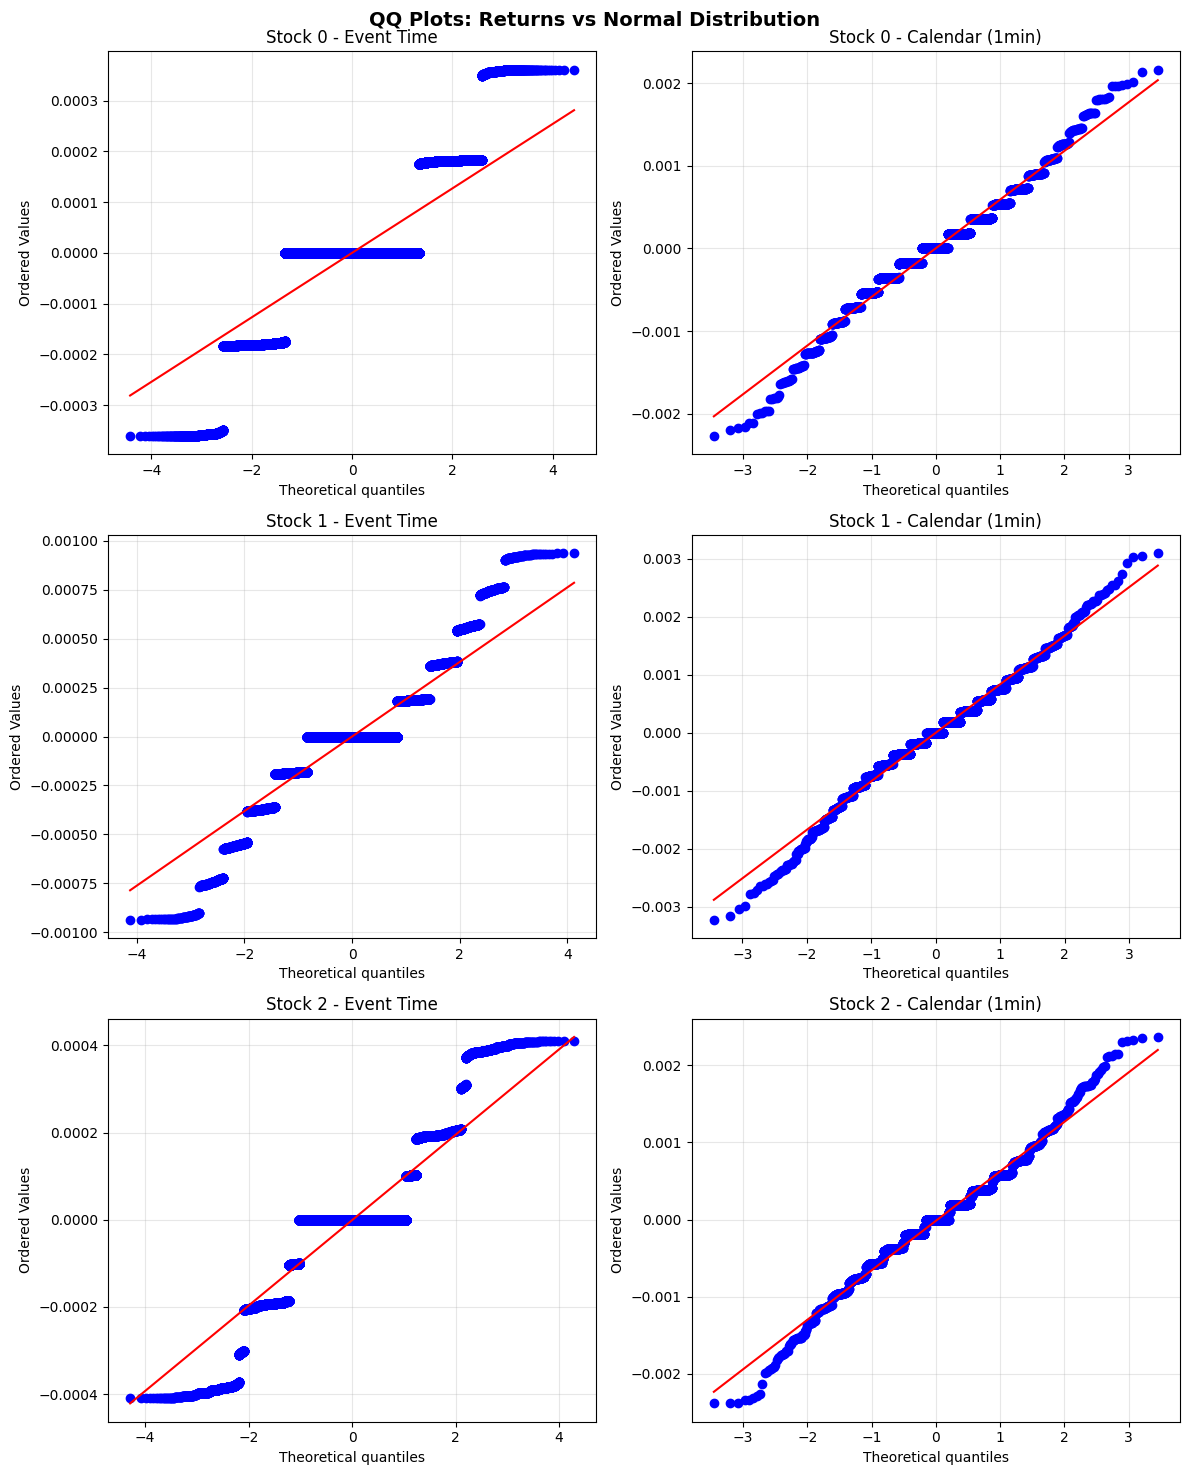

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('QQ Plots: Returns vs Normal Distribution', fontsize=14, fontweight='bold')

for i, stock in enumerate(calendar_returns.keys()):
    returns_event = event_time_returns[stock]
    returns_event_clean = returns_event[np.abs(returns_event) < np.percentile(np.abs(returns_event), 99)]
    
    stats.probplot(returns_event_clean, dist="norm", plot=axes[i, 0])
    axes[i, 0].set_title(f'Stock {stock} - Event Time')
    axes[i, 0].grid(True, alpha=0.3)
    
    returns_cal = calendar_returns[stock]['1min']
    returns_cal_clean = returns_cal[np.abs(returns_cal) < np.percentile(np.abs(returns_cal), 99)]
    
    stats.probplot(returns_cal_clean, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Stock {stock} - Calendar (1min)')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comments on High-Frequency Log-Returns

The analysis of log-returns reveals several important stylized facts:

1. Leptokurtosis (Fat Tails): All returns distributions exhibit excess kurtosis (fat tails) compared to the normal distribution. This is visible in:
   - The histograms showing more mass in the center and tails than a Gaussian
   - QQ plots showing deviations from the 45° line in the tails
   - Kurtosis values significantly greater than 0 (the value for a normal distribution)

2. Higher Kurtosis at Higher Frequencies: The trade-by-trade (event time) returns show higher kurtosis than the calendar time returns sampled at lower frequencies. This is because:
   - Microstructure noise is more pronounced at high frequencies
   - Bid-ask bounce effects inflate the variance and kurtosis

3. Aggregational Gaussianity: As the sampling frequency decreases (from 1s to 5min), the distribution becomes closer to Gaussian due to the Central Limit Theorem. Lower frequency returns aggregate more individual price changes.

4. Event Time vs Calendar Time:
   - Event time treats each trade equally, which may overweight high-activity periods
   - Calendar time weights each observation by time, providing a more balanced view of the price evolution

5. Near-Zero Mean: The mean of log-returns is very close to zero at all frequencies, as expected for short-term returns.

---
## Summary

This analysis of high-frequency trades data has revealed:

1. Dataset Quality (1.1): The data is clean with no missing values. Multiple trades can occur at the same timestamp (sometimes 100+), and multiple unique prices can be observed at the same timestamp, suggesting timestamp truncation or order book sweeps.

2. Tick Sizes (1.2): Each stock has a minimum price increment that affects market quality and trading costs.

3. Intraday Activity (1.3): Trading follows the classic U-shaped pattern with high activity at open and close.

4. Volatility-Volume (1.4): Strong positive correlation exists between volatility and trading activity, consistent with information-based theories.

5. Log-Returns (1.5): Returns exhibit fat tails at all frequencies, with the effect diminishing as the sampling frequency decreases (aggregational Gaussianity).

---
## 2. Quotes

This section deals with the updates (order book) data only.

In [127]:
# Import data
updates = np.array([[pd.read_csv(f"Data/stock{i}_day{j}_updates.csv.gz") for i in range(0, 3)] for j in range(0, 5)], dtype=object)
df_updates = pd.concat([df_updates.assign(stock=i, day=j) for (j, i), df_updates in np.ndenumerate(updates)], ignore_index=True)
print(f"Total number of updates: {len(df_updates):,}")
print(f"Number of stocks: {df_updates['stock'].nunique()}")
print(f"Number of days: {df_updates['day'].nunique()}")

Total number of updates: 4,705,051
Number of stocks: 3
Number of days: 5


### 2.1 Dataset: General statistical analyses

In [128]:
print("Updates Dataset Overview\n")
print(f"Shape: {df_updates.shape}")
print(f"Columns: {df_updates.columns.tolist()}")
print(f"Type values: {df_updates['type'].unique()}")
print(f"Missing values:\n{df_updates.isnull().sum()}")

for stock in sorted(df_updates['stock'].unique()):
    stock_data = df_updates[df_updates['stock'] == stock]
    print(f"\nStock {stock}:")
    print(f"Total updates: {len(stock_data):,}")
    print(f"Type U (quote updates): {(stock_data['type'] == 'U').sum():,}")
    print(f"Type T (trades): {(stock_data['type'] == 'T').sum():,}")
    valid = stock_data[stock_data['bp'].notna()]
    if len(valid) > 0:
        print(f"  Bid price range: [{valid['bp'].min():.4f}, {valid['bp'].max():.4f}]")
        print(f"  Ask price range: [{valid['ap'].min():.4f}, {valid['ap'].max():.4f}]")

Updates Dataset Overview

Shape: (4705051, 8)
Columns: ['ts', 'type', 'bp', 'bq', 'ap', 'aq', 'stock', 'day']
Type values: <StringArray>
['U', 'T']
Length: 2, dtype: str
Missing values:
ts          0
type        0
bp       2932
bq          0
ap       2932
aq          0
stock       0
day         0
dtype: int64

Stock 0:
Total updates: 1,917,800
Type U (quote updates): 1,840,872
Type T (trades): 76,928
  Bid price range: [54.5200, 57.4100]
  Ask price range: [54.5300, 57.4300]

Stock 1:
Total updates: 758,551
Type U (quote updates): 734,747
Type T (trades): 23,804
  Bid price range: [26.0000, 27.8100]
  Ask price range: [26.0300, 27.8200]

Stock 2:
Total updates: 2,028,700
Type U (quote updates): 1,986,165
Type T (trades): 42,535
  Bid price range: [48.2400, 53.8500]
  Ask price range: [48.2500, 53.8700]


In [129]:
df_updates[['bp', 'bq', 'ap', 'aq']].describe()

bp            bq            ap            aq
count  4.702119e+06  4.705051e+06  4.702119e+06  4.705051e+06
mean   4.921216e+01  5.873813e+02  4.922699e+01  6.099409e+02
std    1.001100e+01  7.898207e+02  1.001085e+01  9.980210e+02
min    2.600000e+01  1.000000e+00  2.603000e+01  1.000000e+00
25%    4.962000e+01  2.350000e+02  4.963000e+01  2.360000e+02
50%    5.243000e+01  4.440000e+02  5.244000e+01  4.580000e+02
75%    5.541000e+01  7.740000e+02  5.542000e+01  8.090000e+02
max    5.741000e+01  5.245800e+04  5.743000e+01  1.074700e+05

### Comments on Updates Dataset

Structure:
- type = 'U': Quote update (change in best bid/ask)
- type = 'T': Trade event
- bp/bq: Best bid price and quantity
- ap/aq: Best ask price and quantity

Observations:
- Some early records have NaN prices (before market open/auction phase)
- Data appears clean after the opening auction
- The dataset is as expected for order book data

---
### 2.2 Prices: best bid price, best ask price, mid price and weighted mid-price

We plot the prices on a 5-minute window.

In [134]:
df_updates['mid_price'] = (df_updates['bp'] + df_updates['ap']) / 2
df_updates['weighted_mid'] = (df_updates['bp'] * df_updates['aq'] + df_updates['ap'] * df_updates['bq']) / (df_updates['bq'] + df_updates['aq'])
df_updates['ts'] = pd.to_datetime(df_updates['ts'])

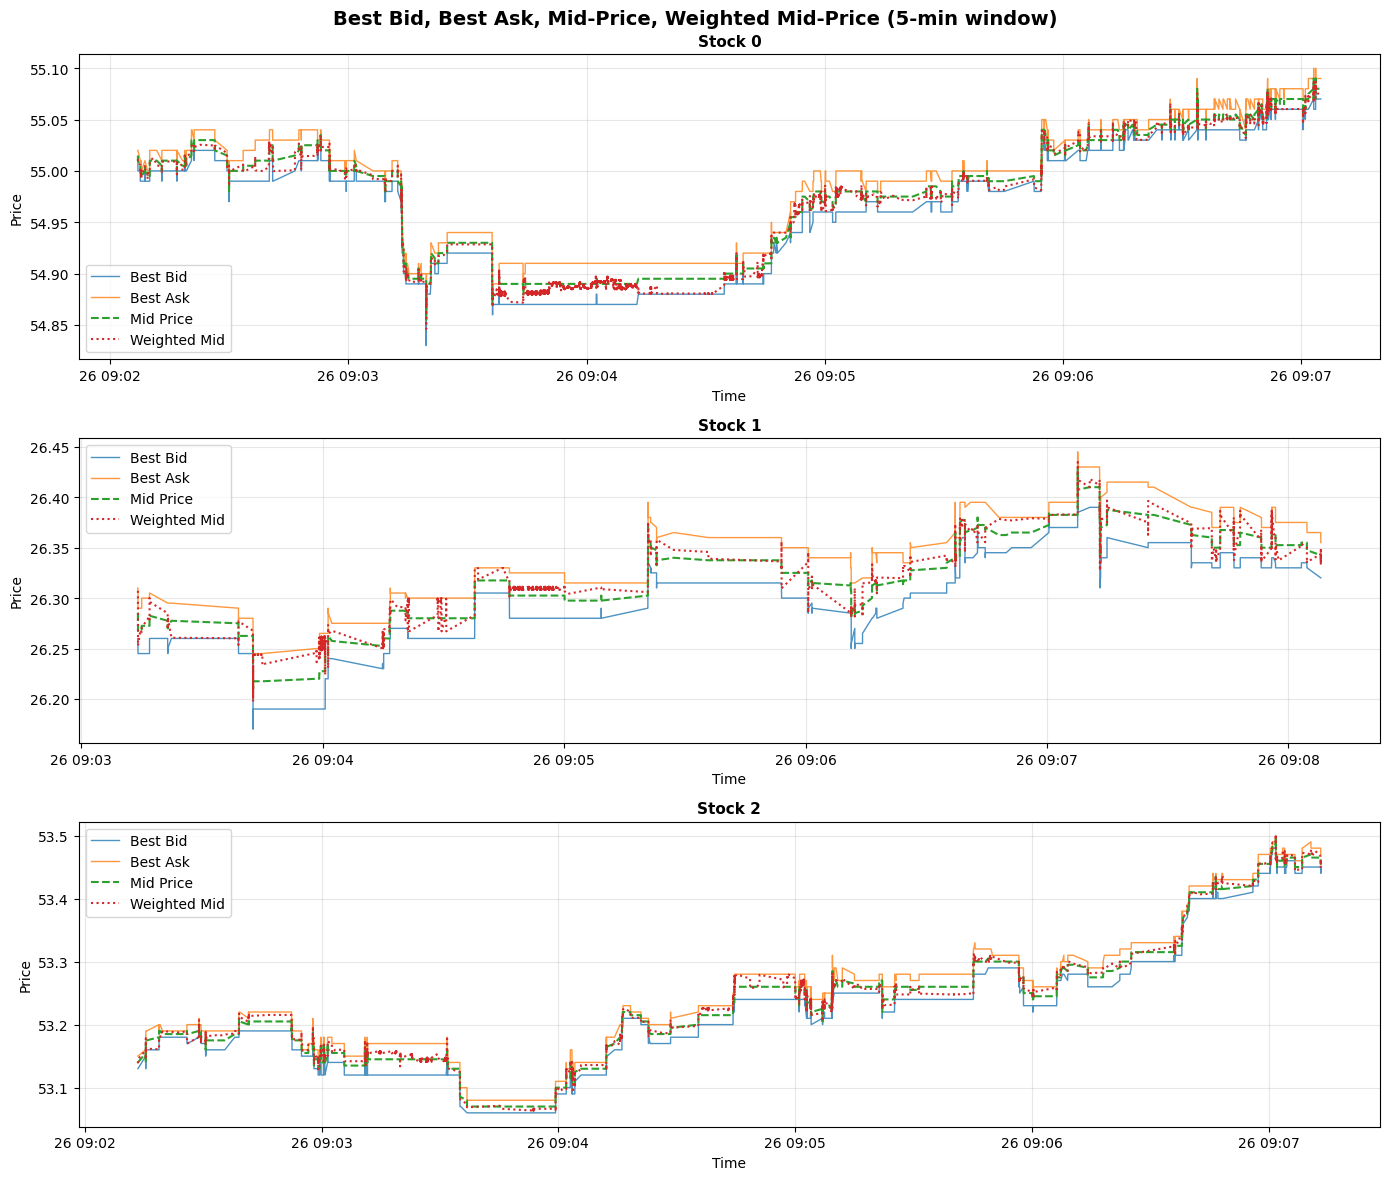

In [135]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Best Bid, Best Ask, Mid-Price, Weighted Mid-Price (5-min window)', fontsize=14, fontweight='bold')

for i, stock in enumerate(sorted(df_updates['stock'].unique())):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['bp'].notna())].copy()
    stock_data = stock_data.sort_values('ts')
    
    start_time = stock_data['ts'].iloc[1000]
    end_time = start_time + pd.Timedelta(minutes=5)
    window = stock_data[(stock_data['ts'] >= start_time) & (stock_data['ts'] <= end_time)]
    
    axes[i].plot(window['ts'], window['bp'], label='Best Bid', alpha=0.8, linewidth=1)
    axes[i].plot(window['ts'], window['ap'], label='Best Ask', alpha=0.8, linewidth=1)
    axes[i].plot(window['ts'], window['mid_price'], label='Mid Price', linestyle='--', linewidth=1.5)
    axes[i].plot(window['ts'], window['weighted_mid'], label='Weighted Mid', linestyle=':', linewidth=1.5)
    axes[i].set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comments on Prices

- Best Bid < Mid-Price < Best Ask: As expected, the mid-price is always between bid and ask.
- Weighted Mid-Price: Closer to the side with more liquidity. If there's more quantity on the ask side, the weighted mid is pulled toward the bid.
- Spread: Visible as the gap between bid and ask prices.

---
### 2.3 Spread: Empirical distribution and comparison

We compute the empirical distribution of the spread in event time and calendar time.

In [136]:
df_updates['spread'] = df_updates['ap'] - df_updates['bp']

In [140]:
print("Spread Statistics (Event Time)\n")

for stock in sorted(df_updates['stock'].unique()):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['spread'].notna()) & (df_updates['spread'] > 0)]
    print(f"\nStock {stock}:")
    print(f"  Mean spread: {stock_data['spread'].mean():.4f}")
    print(f"  Median spread: {stock_data['spread'].median():.4f}")
    print(f"  Std spread: {stock_data['spread'].std():.4f}")
    print(f"  Min/Max: [{stock_data['spread'].min():.4f}, {stock_data['spread'].max():.4f}]")

Spread Statistics (Event Time)


Stock 0:
  Mean spread: 0.0138
  Median spread: 0.0100
  Std spread: 0.0056
  Min/Max: [0.0100, 0.1800]

Stock 1:
  Mean spread: 0.0149
  Median spread: 0.0150
  Std spread: 0.0072
  Min/Max: [0.0050, 0.1900]

Stock 2:
  Mean spread: 0.0157
  Median spread: 0.0150
  Std spread: 0.0065
  Min/Max: [0.0050, 0.2000]


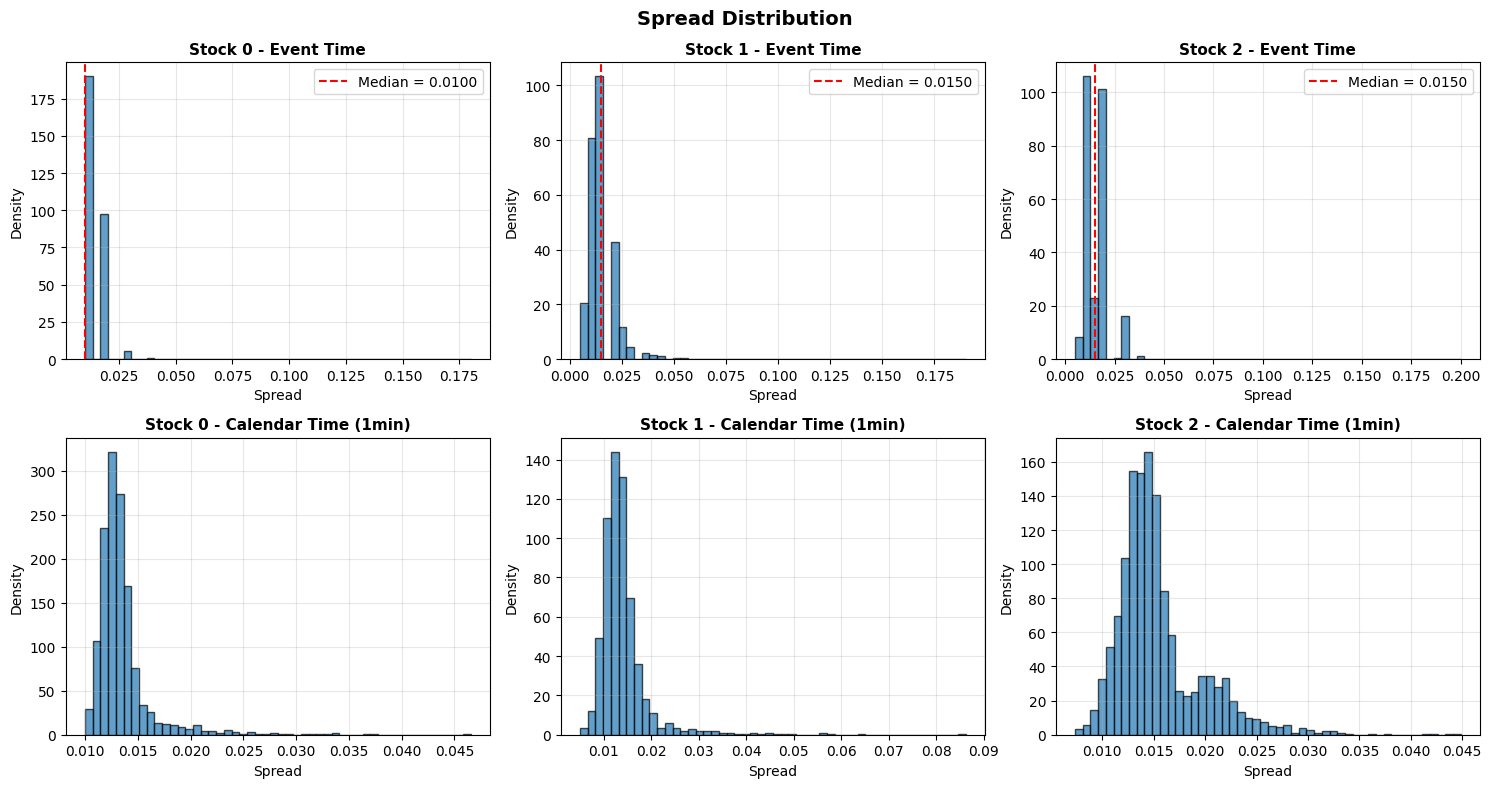

In [141]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Spread Distribution', fontsize=14, fontweight='bold')

for i, stock in enumerate(sorted(df_updates['stock'].unique())):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['spread'].notna()) & (df_updates['spread'] > 0)]
    
    ax = axes[0, i]
    ax.hist(stock_data['spread'], bins=50, edgecolor='black', alpha=0.7, density=True)
    ax.set_title(f'Stock {stock} - Event Time', fontsize=11, fontweight='bold')
    ax.set_xlabel('Spread')
    ax.set_ylabel('Density')
    ax.axvline(x=stock_data['spread'].median(), color='red', linestyle='--', 
               label=f'Median = {stock_data["spread"].median():.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, i]
    stock_data_cal = stock_data.set_index('ts').sort_index()
    spread_resampled = stock_data_cal['spread'].resample('1min').mean().dropna()
    
    ax.hist(spread_resampled, bins=50, edgecolor='black', alpha=0.7, density=True)
    ax.set_title(f'Stock {stock} - Calendar Time (1min)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Spread')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Spread Stationarity Throughout the Day

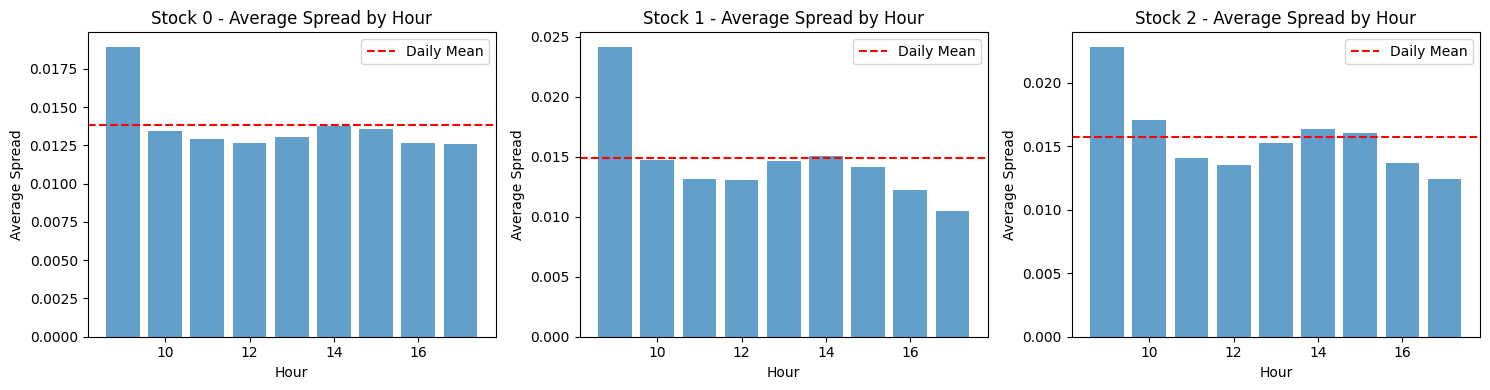

In [143]:
df_updates['hour'] = df_updates['ts'].dt.hour

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, stock in enumerate(df_updates['stock'].unique()):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['spread'].notna()) & (df_updates['spread'] > 0)]
    hourly_spread = stock_data.groupby('hour')['spread'].mean()
    
    axes[i].bar(hourly_spread.index, hourly_spread.values, alpha=0.7)
    axes[i].set_title(f'Stock {stock} - Average Spread by Hour')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Average Spread')
    axes[i].axhline(y=stock_data['spread'].mean(), color='red', linestyle='--', label='Daily Mean')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Comments on Spread

Event Time vs Calendar Time:
- Event time distribution is more peaked around the tick size
- Calendar time smooths out high-frequency variations
- Event time overweights periods of high activity

Stationarity:
- The spread shows intraday variation (tends to be wider at open/close)
- Not perfectly stationary throughout the day
- Wider spreads during high volatility/low liquidity periods

---
### 2.4 Imbalance and mid-price moves: imbalance and prediction of the next mid-price move? Spread?

We analyze whether order book imbalance predicts the next mid-price move.

In [145]:
df_updates['imbalance'] = (df_updates['bq'] - df_updates['aq']) / (df_updates['bq'] + df_updates['aq'])
df_updates['mid_price_change'] = df_updates.groupby('stock')['mid_price'].diff()
df_updates['mid_price_move_sign'] = np.sign(df_updates['mid_price_change'])

In [146]:
print("Imbalance as Predictor of Next Mid-Price Move\n")

for stock in sorted(df_updates['stock'].unique()):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['imbalance'].notna())].copy()
    stock_data['next_mid_move'] = stock_data['mid_price_move_sign'].shift(-1)
    stock_data = stock_data[stock_data['next_mid_move'] != 0].dropna(subset=['imbalance', 'next_mid_move'])
    
    if len(stock_data) > 0:
        corr_imb = stock_data['imbalance'].corr(stock_data['next_mid_move'])
        corr_spread = stock_data['spread'].corr(stock_data['next_mid_move'].abs())
        
        print(f"\nStock {stock}:")
        print(f"  Correlation (Imbalance, Next Mid Move): {corr_imb:.4f}")
        print(f"  Correlation (Spread, |Next Mid Move|): {corr_spread:.4f}")

Imbalance as Predictor of Next Mid-Price Move



c:\Users\adoni\Desktop\High-frequency data and limit order books\MDS-HFD\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\adoni\Desktop\High-frequency data and limit order books\MDS-HFD\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Stock 0:
  Correlation (Imbalance, Next Mid Move): 0.6237
  Correlation (Spread, |Next Mid Move|): nan

Stock 1:
  Correlation (Imbalance, Next Mid Move): 0.5059
  Correlation (Spread, |Next Mid Move|): nan

Stock 2:
  Correlation (Imbalance, Next Mid Move): 0.6027
  Correlation (Spread, |Next Mid Move|): nan


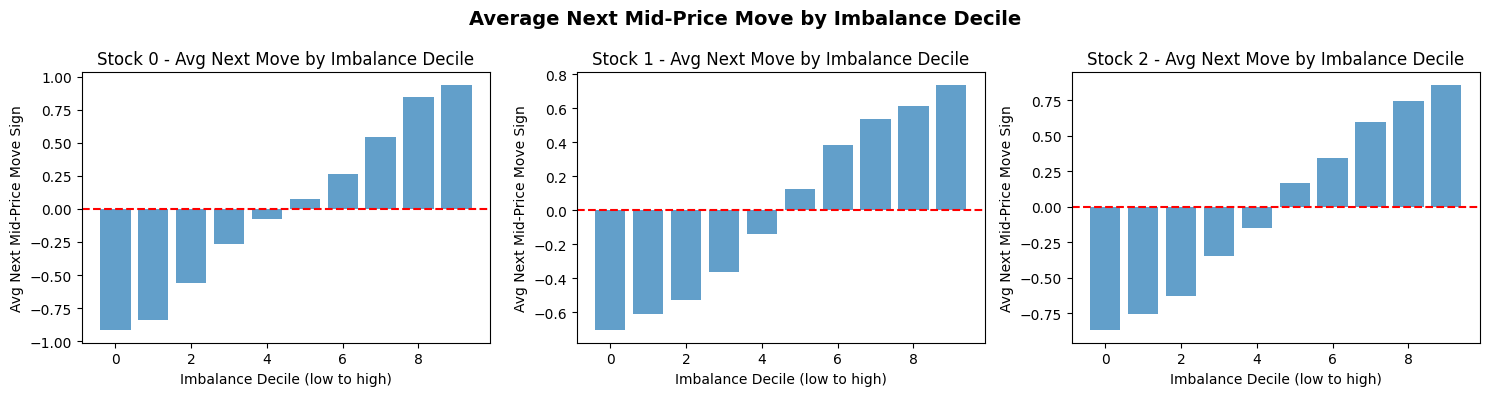

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Average Next Mid-Price Move by Imbalance Decile', fontsize=14, fontweight='bold')

for i, stock in enumerate(df_updates['stock'].unique()):
    stock_data = df_updates[(df_updates['stock'] == stock) & (df_updates['imbalance'].notna())].copy()
    stock_data['next_mid_move'] = stock_data['mid_price_move_sign'].shift(-1)
    stock_data = stock_data[stock_data['next_mid_move'] != 0].dropna(subset=['imbalance', 'next_mid_move'])
    
    imb_bins = pd.qcut(stock_data['imbalance'], q=10, duplicates='drop')
    avg_move = stock_data.groupby(imb_bins)['next_mid_move'].mean()
    
    axes[i].bar(range(len(avg_move)), avg_move.values, alpha=0.7)
    axes[i].set_title(f'Stock {stock} - Avg Next Move by Imbalance Decile')
    axes[i].set_xlabel('Imbalance Decile (low to high)')
    axes[i].set_ylabel('Avg Next Mid-Price Move Sign')
    axes[i].axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

### Comments on Imbalance as Predictor

- Positive correlation between imbalance and next mid-price move
- Higher bid quantity (positive imbalance) → price tends to move up
- Higher ask quantity (negative imbalance) → price tends to move down
- The imbalance is a good predictor of the next mid-price direction
- Spread has weaker predictive power for move magnitude

---
## 3. Trades and Quotes

Combining trades and quotes data for deeper analysis.

### 3.1 Dataset: Trade and update file coherence

In [149]:
print("Dataset Coherence Check\n")
print("=" * 60)

for stock in sorted(df['stock'].unique()):
    trades_stock = df[df['stock'] == stock]
    updates_stock = df_updates[(df_updates['stock'] == stock) & (df_updates['type'] == 'T')]
    
    print(f"\nStock {stock}:")
    print(f"  Trades in trades file: {len(trades_stock):,}")
    print(f"  Trade events in updates file: {len(updates_stock):,}")

Dataset Coherence Check


Stock 0:
  Trades in trades file: 143,963
  Trade events in updates file: 76,928

Stock 1:
  Trades in trades file: 37,522
  Trade events in updates file: 23,804

Stock 2:
  Trades in trades file: 78,209
  Trade events in updates file: 42,535


In [ ]:
df_trades_signed = df.copy()

# Prepare updates dataframe with necessary columns
df_updates_clean = df_updates[df_updates['mid_price'].notna()].copy()
df_updates_clean = df_updates_clean.sort_values('ts')

# Process each stock
for stock in df['stock'].unique():
    print(f"Processing stock {stock}")
    
    stock_mask = df_trades_signed['stock'] == stock
    stock_trades = df_trades_signed[stock_mask].copy()
    stock_updates = df_updates_clean[df_updates_clean['stock'] == stock].copy()
    
    # Find the most recent update before each trade
    merged = pd.merge_asof(
        stock_trades.sort_values('ts'),
        stock_updates[['ts', 'mid_price', 'imbalance', 'spread']],
        on='ts',
        direction='backward',
        suffixes=('', '_prior')
    )
    
    # Calculate trade sign based on trade price vs mid price
    merged['sign'] = np.where(merged['price'] > merged['mid_price'], 1,
                              np.where(merged['price'] < merged['mid_price'], -1, 0))
    merged['prior_imbalance'] = merged['imbalance']
    merged['prior_spread'] = merged['spread']
    
    # Update the main dataframe
    df_trades_signed.loc[stock_mask, 'sign'] = merged.set_index(merged.index)['sign']
    df_trades_signed.loc[stock_mask, 'prior_imbalance'] = merged.set_index(merged.index)['prior_imbalance']
    df_trades_signed.loc[stock_mask, 'prior_spread'] = merged.set_index(merged.index)['prior_spread']

print("\nTrade signing complete. Sign distribution:")
print(df_trades_signed['sign'].value_counts())

Processing stock 0...
Processing stock 1...
Processing stock 2...

Trade signing complete. Sign distribution:
sign
 1.0    47649
-1.0    44082
 0.0    22969
Name: count, dtype: int64


### Comments on Trade Signing

We use the Lee-Ready algorithm to sign trades:
- Compare trade price to mid-price
- Trade above mid → Buy (sign = +1)
- Trade below mid → Sell (sign = -1)
- Trade at mid → Unknown (sign = 0)

---
### 3.2 Imbalance and trades: imbalance and prediction of the next trade sign? Spread?

In [153]:
print("Imbalance as Predictor of Trade Sign\n")

for stock in sorted(df_trades_signed['stock'].unique()):
    stock_data = df_trades_signed[(df_trades_signed['stock'] == stock) & 
                           (df_trades_signed['sign'] != 0) &
                           (df_trades_signed['prior_imbalance'].notna())]
    
    if len(stock_data) > 0:
        corr = stock_data['prior_imbalance'].corr(stock_data['sign'])
        print(f"\nStock {stock}:")
        print(f"  Correlation (Prior Imbalance, Trade Sign): {corr:.4f}")
        print(f"  N observations: {len(stock_data):,}")

Imbalance as Predictor of Trade Sign


Stock 0:
  Correlation (Prior Imbalance, Trade Sign): 0.4359
  N observations: 69,776

Stock 1:
  Correlation (Prior Imbalance, Trade Sign): 0.2879
  N observations: 4,449

Stock 2:
  Correlation (Prior Imbalance, Trade Sign): 0.2493
  N observations: 17,506


----
### 3.3 Autocorrelations: Autocorrelations of trade signs

Trade signs show positive autocorrelation at short lags, indicating that trades cluster by direction. This reflects order splitting where large orders are broken into smaller pieces executed over time. The autocorrelation decays slowly, demonstrating long memory in trade signs, a well-documented stylized fact in market microstructure.

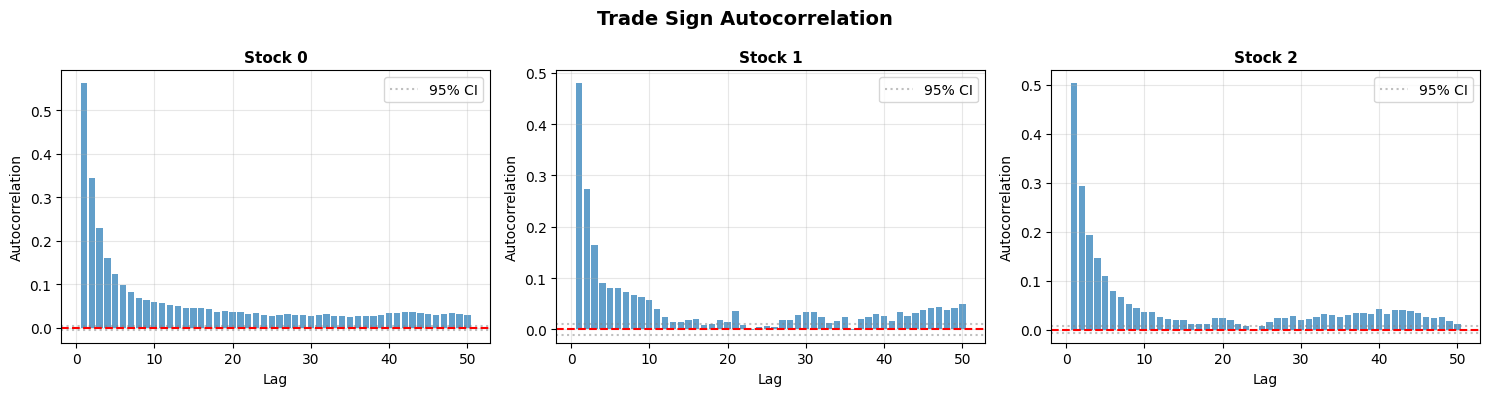

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Trade Sign Autocorrelation', fontsize=14, fontweight='bold')

for i, stock in enumerate(sorted(df_trades_signed['stock'].unique())):
    stock_data = df_trades_signed[(df_trades_signed['stock'] == stock) & (df_trades_signed['sign'] != 0)]
    signs = stock_data['sign'].values
    
    max_lag = 50
    autocorrs = [pd.Series(signs).autocorr(lag=lag) for lag in range(1, max_lag + 1)]
    
    axes[i].bar(range(1, max_lag + 1), autocorrs, alpha=0.7)
    axes[i].set_title(f'Stock {stock}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')
    axes[i].axhline(y=0, color='red', linestyle='--')
    conf = 1.96/np.sqrt(len(signs))
    axes[i].axhline(y=conf, color='gray', linestyle=':', alpha=0.5, label='95% CI')
    axes[i].axhline(y=-conf, color='gray', linestyle=':', alpha=0.5)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comments on Trade Sign Autocorrelation

- Positive autocorrelation at short lags: trades tend to cluster by direction
- This reflects order splitting: large orders are broken into smaller pieces executed over time
- Autocorrelation decays slowly → long memory in trade signs
- This is a well-known stylized fact in market microstructure literature


---
# Final Summary

## Question 1 - Trades:
- 1.1: Dataset is clean, multiple trades can occur at same timestamp
- 1.2: Tick sizes identified for each stock
- 1.3: Intraday activity follows U-shaped pattern
- 1.4: Positive correlation between volatility and volume
- 1.5: Log-returns exhibit fat tails, aggregational Gaussianity

## Question 2 - Quotes:
- 2.1: Data clean, contains quote updates (U) and trades (T)
- 2.2: Bid < Mid < Ask, weighted mid closer to more liquid side
- 2.3: Spread distribution peaked at tick size, not perfectly stationary
- 2.4: Imbalance is a good predictor of mid-price direction

## Question 3 - Trades and Quotes:
- 3.1: Files are coherent, trades signed using Lee-Ready algorithm
- 3.2: Imbalance predicts trade sign (positive correlation)
- 3.3: Trade signs show positive autocorrelation (order splitting)